# RMSD

Analyse MD data with MDAnalysis to get the RMSF to the Holo state

In [ ]:
import csv
import scipy.stats
import os
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

from collections import Counter
import datetime
import gzip
import pathlib
import os
import plotly.graph_objects as go
import kaleido

import matplotlib.pyplot as plt
import numpy
import scipy
from scipy import ndimage

%matplotlib inline

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
NN_training_dir = f"{os.getcwd()}/../ensembleFolding/exp2_enzyme_preliminary/bin/32sims"
os.makedirs(NN_training_dir, exist_ok=True)

In [34]:
sims = range(33, 0, -1)
# sims = range(1, 11)
results = {}

for sim in sims:
    apo_top = "Simulations/Apo/1anf_malremoved_t3p.parm7"
    apo_dcd = f"Simulations/Apo/simulation_{sim:02d}/npt_production_{sim:02d}.dcd"    
    hol_top = "Simulations/Holo/1anf_mal_t3p.parm7"
    hol_dcd = f"Simulations/Holo/simulation_{sim:02d}/npt_production_{sim:02d}.dcd"

    apo_crystal = f"{os.getcwd()}/Simulations/Apo/1anf_malremoved_tleap.pdb"  # Replace with the actual path to the apo crystal structure
    hol_crystal = f"{os.getcwd()}/Simulations/Holo/1omp.pdb"  # Replace with the actual path to the apo crystal structure

    # Load the apo trajectory
    u = mda.Universe(apo_top, apo_dcd)

    average = align.AverageStructure(u, u, select='protein and name CA', ref_frame=0).run()
    ref = average.results.universe

    # Load the apo crystal structure
    u_crystal_apo = mda.Universe(apo_crystal)

    # Load the holo crystal structure
    u_crystal_hol = mda.Universe(hol_crystal)

    # Align the apo crystal structure to the reference
    align.AlignTraj(u_crystal_apo, ref, select='protein and name CA', in_memory=True).run()

    # Align the holo crystal structure to the reference
    align.AlignTraj(u_crystal_hol, ref, select='protein and name CA', in_memory=True).run()

    # Select the protein atoms in the apo trajectory and the apo crystal structure
    protein_atoms_traj_apo = u.select_atoms('protein and name CA')
    protein_atoms_crystal_apo = u_crystal_apo.select_atoms('protein and name CA')

    # Select the protein atoms in the holo trajectory and the holo crystal structure
    protein_atoms_crystal_hol = u_crystal_hol.select_atoms('protein and name CA')

    # Calculate RMSD for apo
    RMSD_hol = rms.RMSD(protein_atoms_traj_apo, protein_atoms_crystal_apo).run()

    # Calculate RMSD for holo
    RMSD_apo = rms.RMSD(protein_atoms_traj_apo, protein_atoms_crystal_hol).run()

    # Extract timeseries data using the `.timeseries()` method
    # Shape: (num_frames, num_CA_atoms, 3)
    uptoIdx = np.ceil(200 / 200 * u.trajectory.n_frames).astype(int)
    Xtraj = np.empty((uptoIdx, protein_atoms_traj_apo.n_atoms, 3))

    # Iterate over the entire trajectory and store Cα positions
    for i, y_clustered in enumerate(u.trajectory[:uptoIdx]):
        Xtraj[i] = protein_atoms_traj_apo.positions  # Store positions of Cα atoms

    # Store results in the dictionary
    results[sim] = {
        'RMSD_apo': RMSD_apo,
        'RMSD_hol': RMSD_hol,
        'protein_atoms_traj_apo': protein_atoms_traj_apo,
        'protein_atoms_crystal_apo': protein_atoms_crystal_apo,
        'protein_atoms_crystal_hol': protein_atoms_crystal_hol,
        'Xtraj': Xtraj
    }

    # Plot RMSD against time for both apo and holo
    plt.figure(figsize=(6, 4))
    plt.plot(RMSD_hol.rmsd[:, 1], RMSD_hol.rmsd[:, 2], label=f'RMSD to Holo')
    plt.plot(RMSD_apo.rmsd[:, 1], RMSD_apo.rmsd[:, 2], label=f'RMSD to Apo')
    plt.xlabel('Time (fs)')
    plt.ylabel('RMSD (Å)')
    plt.title(f'Simulation {sim}: RMSD')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"{os.getcwd()}/Simulations/Apo/simulation_{sim:02d}/RMSD_{sim}.png")
    plt.savefig(f"{os.getcwd()}/Simulations/Apo/simulation_{sim:02d}/RMSD_{sim}.pdf")
    plt.savefig(f"{NN_training_dir}/RMSD_to_closed_{sim}.png")
    plt.savefig(f"{NN_training_dir}/RMSD_to_closed_{sim}.pdf")
    # plt.show()
    plt.close()
    
    # Scatter plot: RMSD to Apo vs RMSD to Holo
    plt.figure(figsize=(6, 5))
    plt.scatter(RMSD_apo.rmsd[:, 2], RMSD_hol.rmsd[:, 2], c=np.arange(len(RMSD_apo.rmsd[:, 2])), cmap='viridis', alpha=0.5, label=f'Simulation {sim}')
    plt.xlabel('RMSD to Apo (Å)')
    plt.ylabel('RMSD to Holo (Å)')
    plt.title(f'Simulation {sim}: RMSD to Apo vs RMSD to Holo')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"{os.getcwd()}/Simulations/Apo/simulation_{sim:02d}/RMSD_scatter_{sim}.png")
    plt.savefig(f"{os.getcwd()}/Simulations/Apo/simulation_{sim:02d}/RMSD_scatter_{sim}.pdf")
    plt.savefig(f"{NN_training_dir}/RMSD_scatter_{sim}.png")
    plt.savefig(f"{NN_training_dir}/RMSD_scatter_{sim}.pdf")
    # plt.show()
    plt.close()
    
    import pyemma
    from sklearn.preprocessing import StandardScaler

    # Reshape Xtraj to (n_frames, n_features) where n_features = 3 * n_atoms
    X_flat = Xtraj.reshape(Xtraj.shape[0], -1)

    # Optional: normalize the data (good practice)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)

    # Use PyEMMA's TICA
    tica_lag = 10  # adjust depending on your system
    tica_model = pyemma.coordinates.tica(data=[X_scaled], lag=tica_lag, dim=2)  # dim=2 for 2D reduction

    # Get the projected trajectory
    X_tica = tica_model.get_output()[0]  # shape: (n_frames - lag, dim)

    # Save to results
    results[sim]['X_tica'] = X_tica

    # Optional: Plot
    plt.figure(figsize=(6, 5))
    plt.plot(X_tica[:, 0], X_tica[:, 1], '.', alpha=0.5)
    plt.xlabel('TIC 1')
    plt.ylabel('TIC 2')
    plt.title(f'TICA Projection - Simulation {sim}')
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"{NN_training_dir}/TICA_{sim}.png")
    plt.savefig(f"{NN_training_dir}/TICA_{sim}.pdf")
    # plt.show()
    plt.close()


/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.

In [249]:
# sims = range(33, 0, -1)
# results = {}

apo_crystal = f"{os.getcwd()}/Simulations/Apo/1anf_malremoved_tleap.pdb"  # Replace with the actual path to the apo crystal structure
hol_crystal = f"{os.getcwd()}/Simulations/Holo/1omp.pdb"  # Replace with the actual path to the apo crystal structure

# Load the apo crystal structure
u_crystal_apo = mda.Universe(apo_crystal)

# Load the holo crystal structure
u_crystal_hol = mda.Universe(hol_crystal)
    
atom1_crystal = u_crystal_apo.select_atoms('resid 15 and name CA')
atom2_crystal = u_crystal_apo.select_atoms('resid 210 and name CA')
apo_distance = np.linalg.norm(atom1_crystal.positions - atom2_crystal.positions)

atom1_crystal = u_crystal_hol.select_atoms('resid 15 and name CA')
atom2_crystal = u_crystal_hol.select_atoms('resid 210 and name CA')
holo_distance = np.linalg.norm(atom1_crystal.positions - atom2_crystal.positions)

distances_42_210 = []

for sim in sims:
    apo_top = "Simulations/Apo/1anf_malremoved_t3p.parm7"
    apo_dcd = f"Simulations/Apo/simulation_{sim:02d}/npt_production_{sim:02d}.dcd"    
    hol_top = "Simulations/Holo/1anf_mal_t3p.parm7"
    hol_dcd = f"Simulations/Holo/simulation_{sim:02d}/npt_production_{sim:02d}.dcd"

    # Load the apo trajectory
    u = mda.Universe(apo_top, apo_dcd)

    # calculate the Euclidean distance between 15-th and 210-th residues across the trajectory
    atom1 = u.select_atoms('resid 42 and name CA')
    atom2 = u.select_atoms('resid 210 and name CA')
    distances = []
    for ts in u.trajectory:
        distance = np.linalg.norm(atom1.positions - atom2.positions)
        distances.append(distance)
    distances = np.array(distances)
    
    distances_42_210.append(distances)
    
    save_dir1 = f"{os.getcwd()}/Simulations/Apo/simulation_{sim:02d}/plots/"
    save_dir2 = f"{os.getcwd()}/Simulations/Apo/plots_32sims/"
    os.makedirs(save_dir1, exist_ok=True)
    os.makedirs(save_dir1+"pdf/", exist_ok=True)
    os.makedirs(save_dir2, exist_ok=True)
    os.makedirs(save_dir2+"pdf/", exist_ok=True)
    
    # Plot the distances
    plt.figure(figsize=(6, 4))
    plt.plot(np.arange(len(distances))/5, distances, label='Distance between residues 15 and 210')
    plt.axhline(y=apo_distance, color='b', linestyle='--', label='Apo Crystal Distance')
    plt.axhline(y=holo_distance, color='g', linestyle='--', label='Holo Crystal Distance')
    plt.xlabel('Time (ns)')
    plt.ylabel('Distance (Å)')
    plt.title(f'Simulation {sim}: Distance between residues 15 and 210')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig(save_dir1+f"distance_42_210_{sim}.png")
    plt.savefig(save_dir1+"pdf/"+f"distance_42_210_{sim}.pdf")
    plt.savefig(save_dir2+f"distance_42_210_{sim}.png")
    plt.savefig(save_dir2+"pdf/"+f"distance_42_210_{sim}.pdf")
    plt.close()
    
    # load the energy data from npt_production_{sim}.csv file
    energy_data = pd.read_csv(f"Simulations/Apo/simulation_{sim:02d}/npt_production_{sim:02d}.csv")
    time = energy_data["Time (ps)"]
    potential_energy = energy_data["Potential Energy (kJ/mole)"]
    kinetic_energy = energy_data["Kinetic Energy (kJ/mole)"]
    
    # Combine potential, kinetic, and total energy plots into one
    total_energy = potential_energy + kinetic_energy
    plt.figure(figsize=(6, 4))
    plt.plot(time / 200, potential_energy, label='Potential Energy', color='r')
    plt.plot(time / 200, kinetic_energy, label='Kinetic Energy', color='b')
    plt.plot(time / 200, total_energy, label='Total Energy', color='g')
    plt.xlabel('Time (ns)')
    plt.ylabel('Energy (kJ/mole)')
    plt.title(f'Simulation {sim}: Energy Profiles')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig(save_dir1 + f"combined_energy_{sim}.png")
    plt.savefig(save_dir1 + "pdf/" + f"combined_energy_{sim}.pdf")
    plt.savefig(save_dir2 + f"combined_energy_{sim}.png")
    plt.savefig(save_dir2 + "pdf/" + f"combined_energy_{sim}.pdf")
    plt.close()
    
distances_42_210 = np.array(distances_42_210)
print(distances_42_210.shape)

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes inde

(32, 1000)


In [250]:
print(distances_42_210.shape)

(32, 1000)


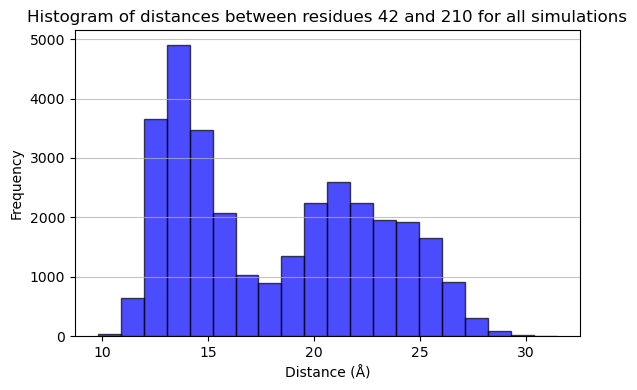

In [256]:
# plot the histogram of distances
plt.figure(figsize=(6, 4))
plt.hist(distances_42_210.flatten(), bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Distance (Å)')
plt.ylabel('Frequency')
plt.title('Histogram of distances between residues 42 and 210 for all simulations')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


In [40]:
sims = sims[1:]
Xtraj_all = np.array([results[sim]['Xtraj'].reshape(1000, -1) for sim in sims[1:]])
Xtraj_all.shape

(31, 1000, 1110)

In [41]:
import pyemma
from deeptime.decomposition import TICA
from sklearn.preprocessing import StandardScaler
import mdtraj as md

# Reshape Xtraj to (n_frames, n_features) where n_features = 3 * n_atoms
Xtraj_all = np.array([results[sim]['Xtraj'].reshape(1000, -1) for sim in sims])
X_flat = Xtraj_all

# # Optional: normalize the data (good practice)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_flat)
# X_flat = X_flat - X_flat.mean(axis=0)
# X_flat = X_flat / X_flat.std(axis=0)

apo_top = "Simulations/Apo/1anf_malremoved_t3p.parm7"
apo_dcd = f"Simulations/Apo/simulation_{sim:02d}/npt_production_{sim:02d}.dcd"    
top = md.load(apo_dcd, top=apo_top).topology

# Step 2: Get indices of Cα atoms
ca_indices = [a.index for a in top.atoms if a.name == 'CA']

# Iterate over a range of tica_lag values and plot the results
for tica_lag in range(1, 3):
    plt.figure(figsize=(6, 5))
    for sim in sims:
        
        apo_top = "Simulations/Apo/1anf_malremoved_t3p.parm7"
        apo_dcd = f"Simulations/Apo/simulation_{sim:02d}/npt_production_{sim:02d}.dcd"    
        hol_top = "Simulations/Holo/1anf_mal_t3p.parm7"
        hol_dcd = f"Simulations/Holo/simulation_{sim:02d}/npt_production_{sim:02d}.dcd"

        apo_crystal = f"{os.getcwd()}/Simulations/Apo/1anf_malremoved_tleap.pdb"  # Replace with the actual path to the apo crystal structure
        hol_crystal = f"{os.getcwd()}/Simulations/Holo/1omp.pdb"  # Replace with the actual path to the apo crystal structure

        feat = pyemma.coordinates.featurizer(apo_top)
        feat.add_selection(ca_indices)  
        
        # # load the raw dcd data
        dcd_data = pyemma.coordinates.load([apo_dcd], features=feat)
        
        # Use PyEMMA's TICA for each trajectory separately
        # tica_model = pyemma.coordinates.tica(X_flat, lag=tica_lag, dim=2)
        tica_model = pyemma.coordinates.tica(dcd_data, lag=tica_lag, dim=1)

        # Get the projected trajectory
        X_tica = tica_model.get_output()[0]  # shape: (n_frames - lag, dim)

        # Plot each trajectory
        # plt.plot(X_tica[:, 0], X_tica[:, 1], '.', alpha=0.5, label=f'Sim {sim}')
        plt.plot(np.arange(X_tica.shape[0]), X_tica, '.', alpha=0.5, label=f'Sim {sim}')
    
    # plt.xlabel('TIC 1')
    # plt.ylabel('TIC 2')
    plt.xlabel('Timestep')
    plt.ylabel('TIC 1')
    plt.title(f'TICA Projection - tica_lag={tica_lag}')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    # plt.savefig(f"{NN_training_dir}/TICA_tica_lag_{tica_lag}.png")
    # plt.savefig(f"{NN_training_dir}/TICA_tica_lag_{tica_lag}.pdf")
    plt.show()


KeyboardInterrupt: 

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


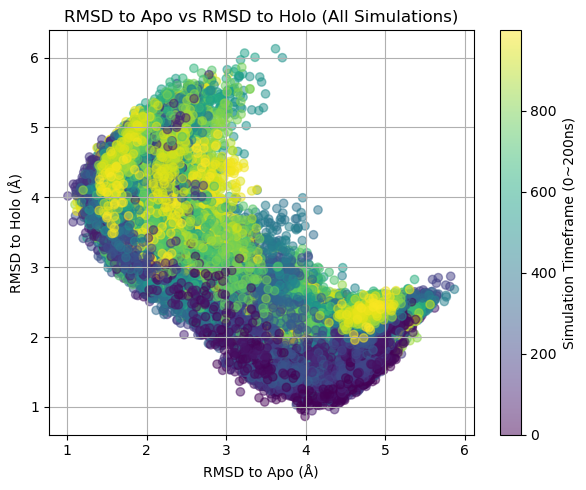

In [43]:
# Concatenate RMSD data across all simulations data across all simulations
RMSD_apo_all = np.vstack([results[sim]['RMSD_apo'].rmsd[:, 2] for sim in sims])
RMSD_hol_all = np.vstack([results[sim]['RMSD_hol'].rmsd[:, 2] for sim in sims])

# Scatter plot: RMSD to Apo vs RMSD to Holo for all simulationsations
plt.figure(figsize=(6, 5))
for idx, (rmsd_apo, rmsd_hol) in enumerate(zip(RMSD_apo_all, RMSD_hol_all)):
    plt.scatter(rmsd_apo, rmsd_hol, c=np.arange(len(rmsd_apo)), cmap='viridis', alpha=0.5)
plt.xlabel('RMSD to Apo (Å)')
plt.ylabel('RMSD to Holo (Å)')
plt.title('RMSD to Apo vs RMSD to Holo (All Simulations)')
plt.grid()
plt.tight_layout()
plt.colorbar(label='Simulation Timeframe (0~200ns)')
plt.savefig(f"{NN_training_dir}/RMSD_scatter_all_sims.png")
plt.savefig(f"{NN_training_dir}/RMSD_scatter_all_sims.pdf")
plt.show()


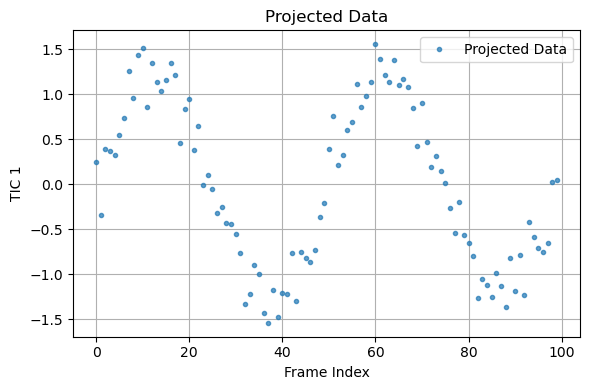

In [9]:
import numpy as np
from pyemma.coordinates import tica
data = np.random.random((100,3)) + np.sin(np.linspace(0, 4*np.pi, 100))[:, np.newaxis]
projected_data = tica(data, lag=2, dim=1).get_output()[0]
plt.figure(figsize=(6, 4))
plt.plot(projected_data, '.', alpha=0.7, label='Projected Data')
plt.xlabel('Frame Index')
plt.ylabel('TIC 1')
plt.title('Projected Data')
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


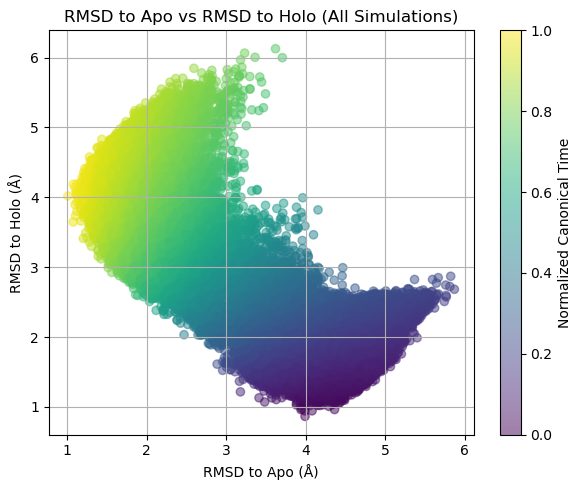

In [103]:
# Concatenate RMSD data across all simulations data across all simulations
RMSD_apo_all = np.vstack([results[sim]['RMSD_apo'].rmsd[:, 2] for sim in sims])
RMSD_hol_all = np.vstack([results[sim]['RMSD_hol'].rmsd[:, 2] for sim in sims])

RMSD_apo_hol = np.stack([RMSD_apo_all, RMSD_hol_all], axis=-1)
canonical_t = (np.linalg.norm(RMSD_apo_hol - np.array([1, 0]), axis=-1)) - (np.linalg.norm(RMSD_apo_hol - np.array([0, 1]), axis=-1))
canonical_tmax = np.max(canonical_t)
canonical_tmin = np.min(canonical_t)
canonical_t = (canonical_t - canonical_tmin) / (canonical_tmax - canonical_tmin)

# Scatter plot: RMSD to Apo vs RMSD to Holo for all simulations
plt.figure(figsize=(6, 5))
scatter = plt.scatter(RMSD_apo_hol[:, :, 0].flatten(), RMSD_apo_hol[:, :, 1].flatten(), c=canonical_t.flatten(), cmap='viridis', alpha=0.5)
plt.xlabel('RMSD to Apo (Å)')
plt.ylabel('RMSD to Holo (Å)')
plt.title('RMSD to Apo vs RMSD to Holo (All Simulations)')
plt.grid()
plt.tight_layout()
cbar = plt.colorbar(scatter)
cbar.set_label('Normalized Canonical Time')
plt.savefig(f"{NN_training_dir}/RMSD_scatter_all_sims_shared_colorbar.png")
plt.savefig(f"{NN_training_dir}/RMSD_scatter_all_sims_shared_colorbar.pdf")
plt.show()


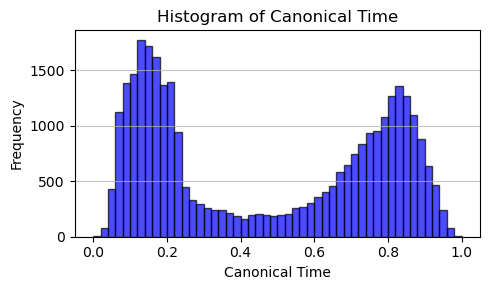

In [104]:
plt.figure(figsize=(5, 3))
plt.hist(canonical_t.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Canonical Time')
plt.ylabel('Frequency')
plt.title('Histogram of Canonical Time')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

In [ ]:
canonical_t.shape

(8, 1000)

In [105]:
import numpy as np
from sklearn.decomposition import PCA

def pca_reduce(x, v, dim=2):
    pca_x = PCA(n_components=dim)
    pca_v = PCA(n_components=dim)
    x_2d = pca_x.fit_transform(x)
    v_2d = pca_v.fit_transform(v)
    return x_2d, v_2d, pca_x, pca_v

def fast_smooth_mean_vector_field_at_xj(v, x, x_j, epsilon, cutoff_factor=2.0):
    distances = np.linalg.norm(x - x_j, axis=1)
    mask = distances < cutoff_factor * epsilon
    if not np.any(mask):
        return np.zeros_like(x_j)
    x_near = x[mask]
    v_near = v[mask]
    d_near = distances[mask]
    weights = np.exp(-d_near**2 / (2 * epsilon**2))
    weight_sum = np.sum(weights)
    if weight_sum == 0:
        return np.zeros_like(x_j)
    return np.sum(weights[:, None] * v_near, axis=0) / weight_sum

def compute_vector_field_on_grid(x_2d, v_2d, grid_size=30, epsilon=0.1, cutoff_factor=2.0):
    # Create 2D mesh grid
    x_min, x_max = x_2d[:, 0].min(), x_2d[:, 0].max()
    y_min, y_max = x_2d[:, 1].min(), x_2d[:, 1].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size)
    )
    grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)  # shape (grid_size**2, 2)

    # Compute smoothed vectors on the grid
    vector_field = np.array([
        fast_smooth_mean_vector_field_at_xj(v_2d, x_2d, pt, epsilon, cutoff_factor)
        for pt in grid_points
    ])
    return xx, yy, vector_field[:, 0].reshape(xx.shape), vector_field[:, 1].reshape(yy.shape)

# === Usage example ===
# Assuming you have x: (N, d) positions and v: (N, d) vectors

def run_vector_field_pipeline(x, v, grid_size=30, epsilon=0.1):
    x_2d, v_2d, pca_x, pca_v = pca_reduce(x, v)
    xx, yy, u, v = compute_vector_field_on_grid(x, v, grid_size, epsilon)
    return xx, yy, u, v, pca_x, pca_v

def plot_vector_field(xx, yy, u, v, save_dir=None):
    plt.figure(figsize=(6, 6))
    plt.quiver(xx, yy, u, v, angles='xy', scale_units='xy', scale=1)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel("Axis 1")
    plt.ylabel("Axis 2")
    plt.title("Smoothed Mean Vector Field (2D)")
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, "vector_field.png"))
        plt.savefig(os.path.join(save_dir, "vector_field.pdf"))
    plt.show()



In [106]:
x0s = RMSD_apo_hol.reshape(-1, 2)
print(x0s.shape)
vs = np.diff(x0s, axis=0)
print(vs.shape)

print(vs.shape, x0s.shape)


(32000, 2)
(31999, 2)
(31999, 2) (32000, 2)


In [107]:
NN_training_dir

'/home/ubuntu22/Documents/PhD/oshea-j-wood-c-pbp-design-2023/../ensembleFolding/exp2_enzyme_preliminary/bin/32sims'

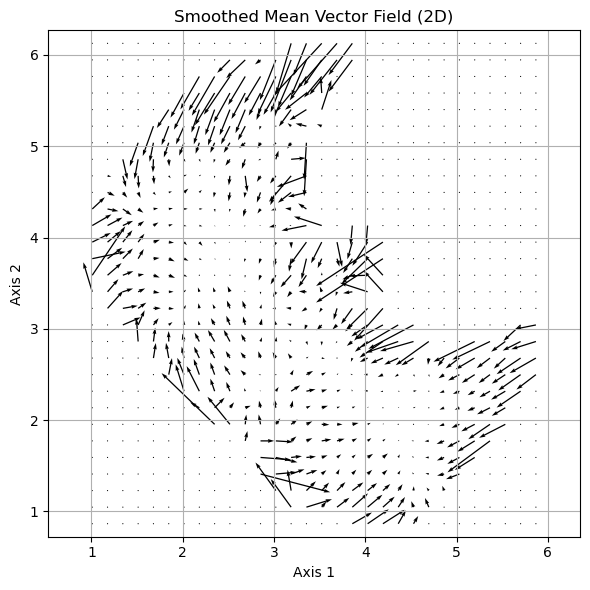

In [108]:
xx, yy, u, v, pca_x, pca_v = run_vector_field_pipeline(x0s[:-1], vs, grid_size=30, epsilon=0.1)
plot_vector_field(xx, yy, u, v, save_dir=NN_training_dir)


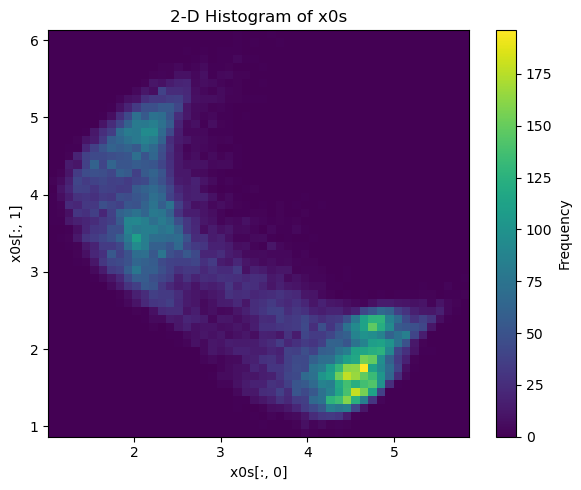

In [109]:
plt.figure(figsize=(6, 5))
plt.hist2d(x0s[:, 0], x0s[:, 1], bins=50, cmap='viridis')
plt.colorbar(label='Frequency')
plt.xlabel('x0s[:, 0]')
plt.ylabel('x0s[:, 1]')
plt.title('2-D Histogram of x0s')
plt.tight_layout()
plt.show()

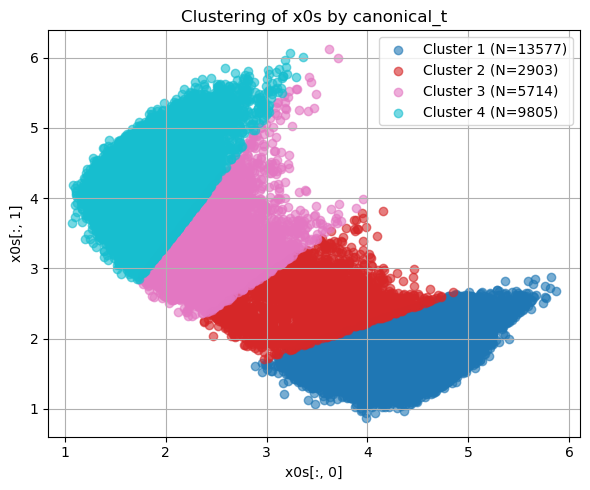

In [110]:
# Define the number of clusters
n_clusters = 4

# Define the cluster boundaries
cluster_boundaries = np.linspace(0, 1, n_clusters + 1)

# Assign each point in x0s to a cluster based on canonical_t
cluster_labels = np.digitize(canonical_t.flatten(), cluster_boundaries) - 1

# Plot the clusters
plt.figure(figsize=(6, 5))
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
for cluster_idx in range(n_clusters):
    cluster_points = x0s[cluster_labels == cluster_idx]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_idx], label=f'Cluster {cluster_idx + 1} (N={len(cluster_points)})', alpha=0.6)

plt.xlabel('x0s[:, 0]')
plt.ylabel('x0s[:, 1]')
plt.title('Clustering of x0s by canonical_t')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

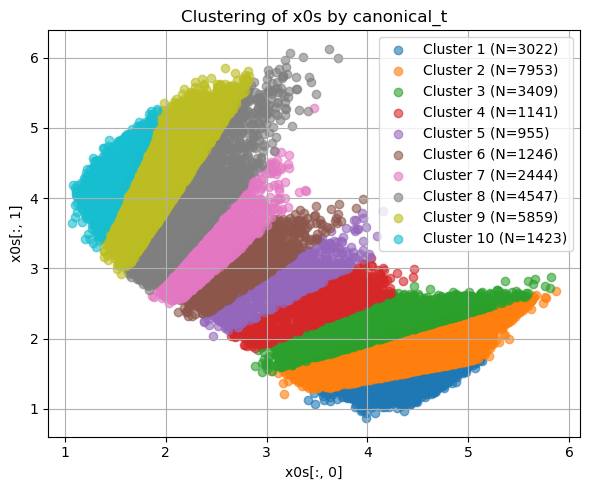

In [111]:
# Define the sliding window width and number of clusters
window_width = 1 / 4
n_clusters = 10

# Define the cluster boundaries
cluster_boundaries = np.linspace(0, 1, n_clusters + 1)

# Assign each point in canonical_t to a cluster based on the cluster boundaries
cluster_labels = np.digitize(canonical_t.flatten(), cluster_boundaries) - 1

# Plot the clusters
plt.figure(figsize=(6, 5))
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
for cluster_idx in range(n_clusters):
    cluster_mask = (cluster_labels == cluster_idx)
    cluster_points = x0s[cluster_mask]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_idx], label=f'Cluster {cluster_idx + 1} (N={len(cluster_points)})', alpha=0.6)

plt.xlabel('x0s[:, 0]')
plt.ylabel('x0s[:, 1]')
plt.title('Clustering of x0s by canonical_t')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


/tmp/ipykernel_3540321/1314385384.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


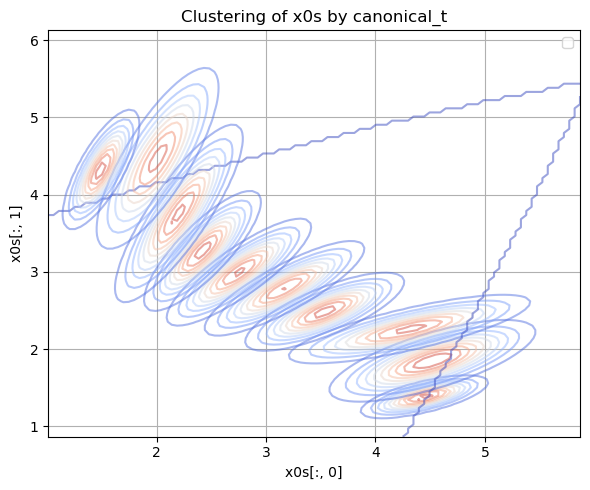

In [260]:
from scipy.stats import multivariate_normal

# Define the sliding window width and number of clusters
window_width = 1 / 4
n_clusters = 10

# Define the cluster boundaries
cluster_boundaries = np.linspace(0, 1, n_clusters + 1)

# Assign each point in canonical_t to a cluster based on the cluster boundaries
cluster_labels = np.digitize(canonical_t.flatten(), cluster_boundaries) - 1

# Create a grid for evaluating the Gaussian PDF
x = np.linspace(x0s[:, 0].min(), x0s[:, 0].max(), 100)
y = np.linspace(x0s[:, 1].min(), x0s[:, 1].max(), 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Plot the clusters
plt.figure(figsize=(6, 5))
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
for cluster_idx in range(n_clusters):
    cluster_mask = (cluster_labels == cluster_idx)
    cluster_points = x0s[cluster_mask]
    
    if len(cluster_points) > 1:  # Ensure there are enough points to calculate mean and covariance
        mean_cluster = np.mean(cluster_points, axis=0)
        cov_cluster = np.cov(cluster_points, rowvar=False)
        
        # Evaluate the Gaussian PDF for the cluster
        rv_cluster = multivariate_normal(mean_cluster, cov_cluster)
        Z_cluster = rv_cluster.pdf(pos)

        # Plot the Gaussian as a contour
        plt.contour(X, Y, Z_cluster, levels=10, alpha=0.5, cmap='coolwarm')

plt.xlabel('x0s[:, 0]')
plt.ylabel('x0s[:, 1]')
plt.title('Clustering of x0s by canonical_t')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


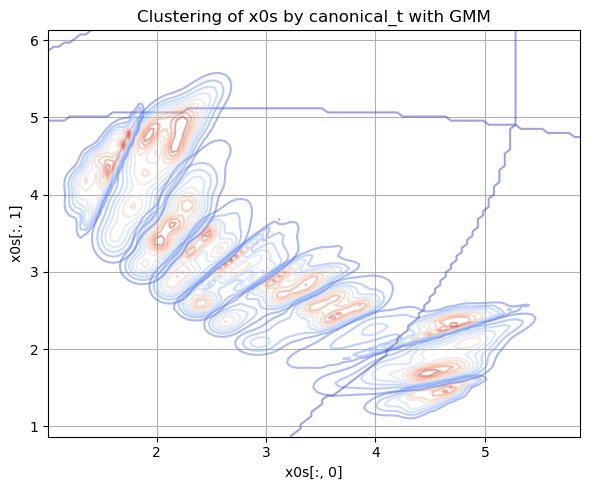

In [113]:
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

# Define the sliding window width and number of clusters
window_width = 1 / 4
n_clusters = 10

# Define the cluster boundaries
cluster_boundaries = np.linspace(0, 1, n_clusters + 1)

# Assign each point in canonical_t to a cluster based on the cluster boundaries
cluster_labels = np.digitize(canonical_t.flatten(), cluster_boundaries) - 1

# Create a grid for evaluating the Gaussian PDF
x = np.linspace(x0s[:, 0].min(), x0s[:, 0].max(), 100)
y = np.linspace(x0s[:, 1].min(), x0s[:, 1].max(), 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Plot the clusters
plt.figure(figsize=(6, 5))
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
for cluster_idx in range(n_clusters):
    cluster_mask = (cluster_labels == cluster_idx)
    cluster_points = x0s[cluster_mask]
    
    if len(cluster_points) > 1:  # Ensure there are enough points to calculate mean and covariance
        # Fit a GMM with 2 Gaussians
        gmm = GaussianMixture(n_components=7, random_state=42)
        gmm.fit(cluster_points)
        
        # Evaluate the GMM for the cluster
        Z_cluster = np.exp(gmm.score_samples(pos.reshape(-1, 2))).reshape(X.shape)

        # Plot the GMM as a contour
        plt.contour(X, Y, Z_cluster, levels=10, alpha=0.5, cmap='coolwarm')

plt.xlabel('x0s[:, 0]')
plt.ylabel('x0s[:, 1]')
plt.title('Clustering of x0s by canonical_t with GMM')
# plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


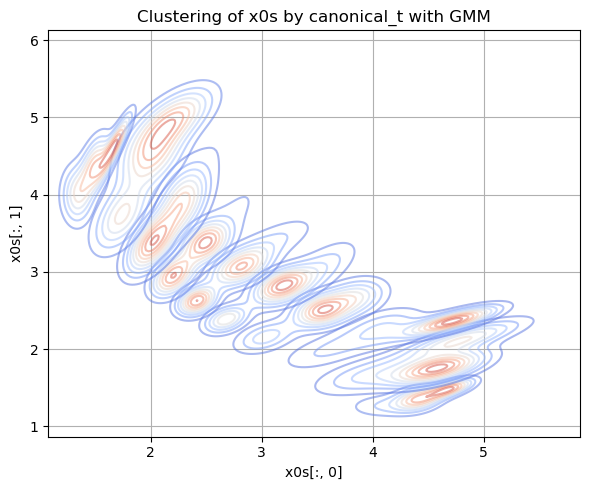

In [262]:
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

# Define the sliding window width and number of clusters
window_width = 1 / 4
n_clusters = 10

# Define the cluster boundaries
cluster_boundaries = np.linspace(0, 1, n_clusters + 1)

# Assign each point in canonical_t to a cluster based on the cluster boundaries
cluster_labels = np.digitize(canonical_t.flatten(), cluster_boundaries) - 1

# Plot the clusters
marginal_distributions = []
marginal_densities = []

plt.figure(figsize=(6, 5))
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
for cluster_idx in range(n_clusters):
    cluster_mask = (cluster_labels == cluster_idx)
    cluster_points = x0s[cluster_mask]
    
    # Create a grid for evaluating the Gaussian PDF
    x = np.linspace(cluster_points[:, 0].min(), cluster_points[:, 0].max(), 100)
    y = np.linspace(cluster_points[:, 1].min(), cluster_points[:, 1].max(), 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    
    if len(cluster_points) > 1:  # Ensure there are enough points to calculate mean and covariance
        # Fit a GMM with 2 Gaussians
        gmm = GaussianMixture(n_components=3, random_state=42, max_iter=1000)
        gmm.fit(cluster_points)
        
        marginal_distributions.append(gmm)
        
        # Evaluate the GMM for the cluster
        Z_cluster = np.exp(gmm.score_samples(pos.reshape(-1, 2))).reshape(X.shape)
        marginal_densities.append((X, Y, Z_cluster))

        # Plot the GMM as a contour
        plt.contour(X, Y, Z_cluster, levels=10, alpha=0.5, cmap='coolwarm')

plt.xlabel('x0s[:, 0]')
plt.ylabel('x0s[:, 1]')
plt.title('Clustering of x0s by canonical_t with GMM')
# plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


sampled_points.shape=(10, 500, 2)


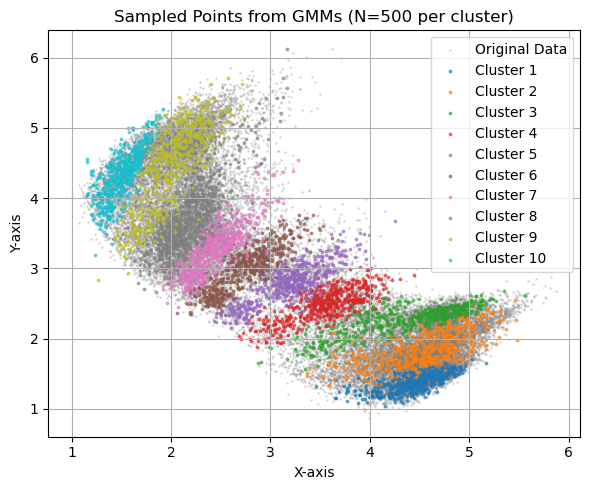

In [282]:
import numpy as np
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt

# Number of points to sample from each GMM
N = 500

# Assuming `marginal_distributions` contains the GMMs for each cluster
sampled_points = []

plt.figure(figsize=(6, 5))
colors = plt.cm.tab10(np.linspace(0, 1, len(marginal_distributions)))

# Plot the original data points
plt.scatter(x0s[:, 0], x0s[:, 1], color='gray', alpha=0.2, label='Original Data', s=1)

for i, gmm in enumerate(marginal_distributions):
    # Sample N points from the GMM
    samples, _ = gmm.sample(N)
    sampled_points.append(samples)
    
    # Plot the sampled points
    plt.scatter(samples[:, 0], samples[:, 1], color=colors[i], alpha=0.6, label=f'Cluster {i + 1}', s=3)
    # plt.scatter(samples[:, 0], samples[:, 1], color=colors[i], alpha=0.6, label=f'Cluster {i + 1}', s=20)

# for i, (X, Y, Z_cluster) in enumerate(marginal_densities):
#     # Plot the GMM as a contour
#     plt.contour(X, Y, Z_cluster, levels=10, alpha=0.5, cmap='coolwarm')

sampled_points = np.array(sampled_points)
print(f"{sampled_points.shape=}")

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Sampled Points from GMMs (N={N} per cluster)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [277]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

def compute_optimal_matchings(clusters):
    """
    Computes optimal one-to-one matchings between successive clusters
    using the Hungarian algorithm (linear sum assignment).

    Args:
        clusters: List of np.ndarray, each of shape (N, 2)

    Returns:
        matchings: List of np.ndarray of shape (N,), where
                   matchings[i][j] = index in clusters[i+1] corresponding to clusters[i][j]
    """
    matchings = []
    for i in range(len(clusters) - 1):
        X_i = clusters[i]
        X_next = clusters[i + 1]
        cost_matrix = cdist(X_i, X_next, metric='sqeuclidean')
        _, col_ind = linear_sum_assignment(cost_matrix)
        matchings.append(col_ind)
    return matchings

def plot_matchings(X1, X2, matching, title="Matching between clusters"):
    """
    Plots the matching between two 2D clusters using arrows.

    Args:
        X1: np.ndarray of shape (N, 2) – source cluster
        X2: np.ndarray of shape (N, 2) – target cluster
        matching: np.ndarray of shape (N,) – indices into X2 corresponding to X1
        title: str – plot title
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(X1[:, 0], X1[:, 1], c='blue', label='Cluster i')
    plt.scatter(X2[:, 0], X2[:, 1], c='red', label='Cluster i+1')

    for j in range(len(X1)):
        pt1 = X1[j]
        pt2 = X2[matching[j]]
        plt.arrow(pt1[0], pt1[1], pt2[0] - pt1[0], pt2[1] - pt1[1],
                  head_width=0.02, alpha=0.2, length_includes_head=True, color='gray')

    plt.legend()
    plt.title(title)
    plt.axis('equal')
    plt.grid(True)
    plt.show()


In [278]:
# Suppose you have a list of clusters: clusters = [X0, X1, ..., X9], each (1000, 2)
matchings = compute_optimal_matchings(sampled_points)
matchings = np.array(matchings)
print(f"{matchings.shape=}")

matchings.shape=(9, 500)


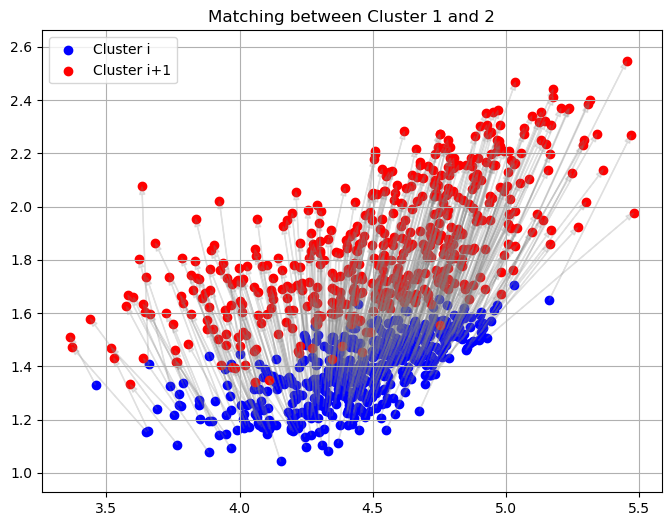

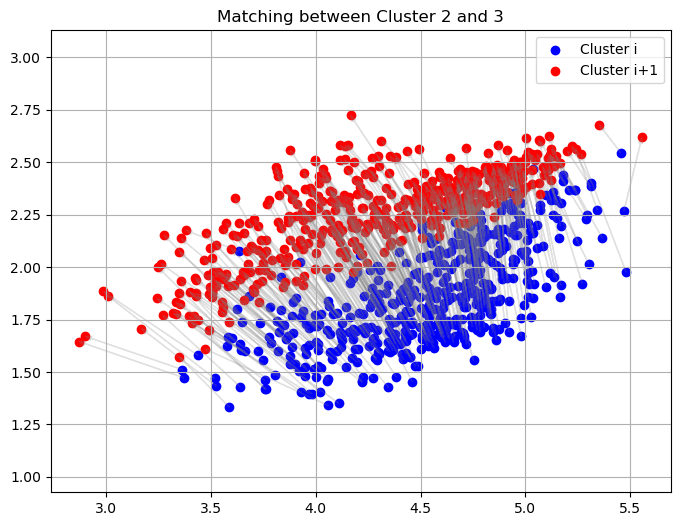

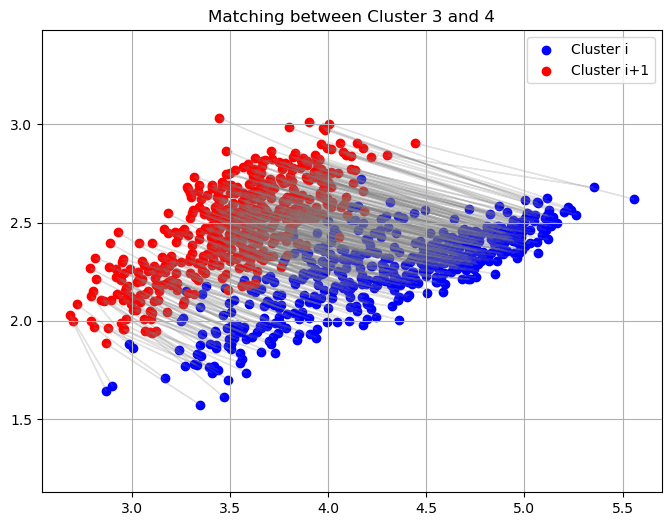

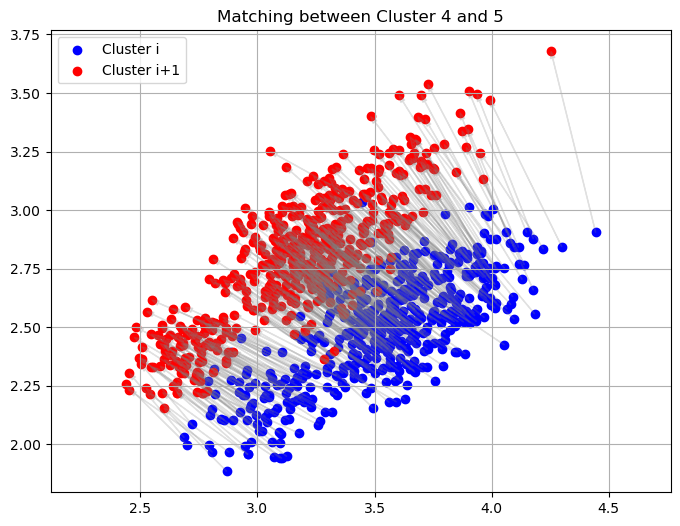

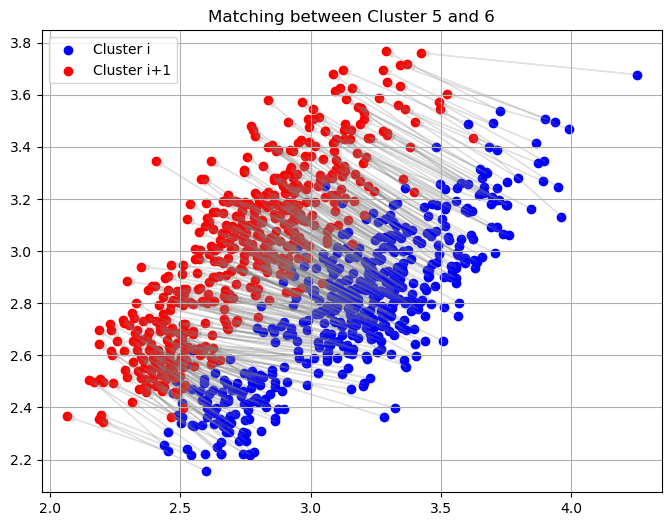

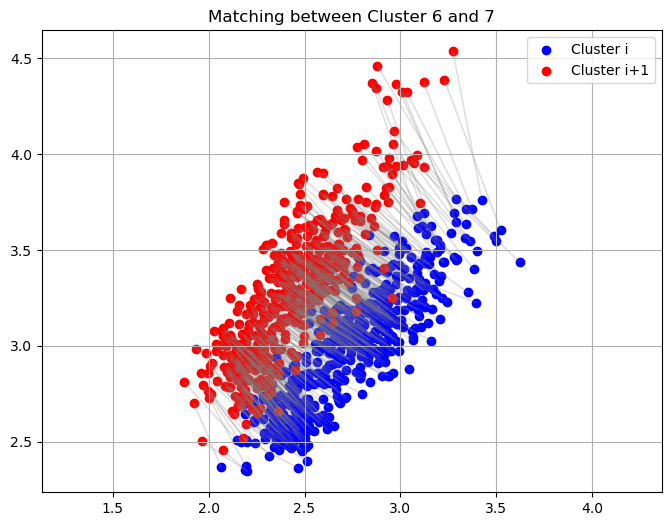

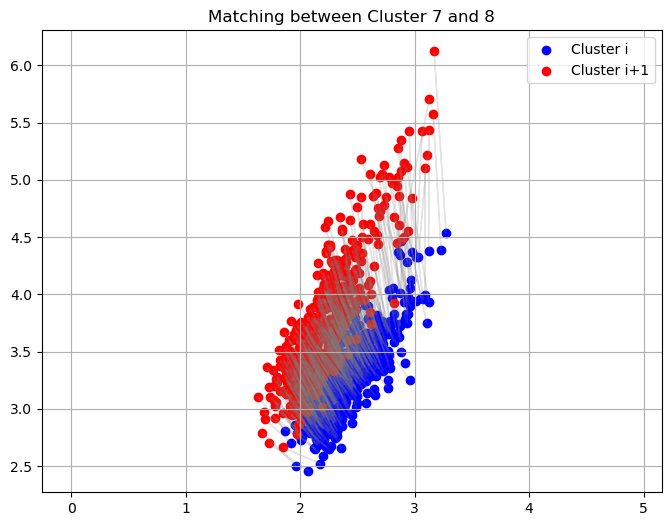

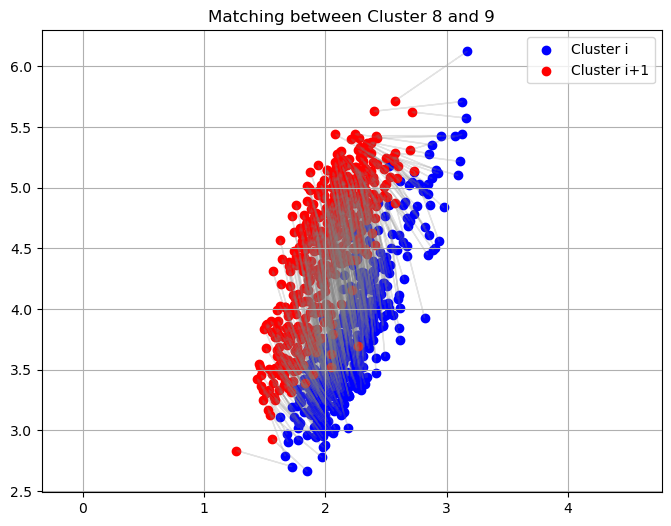

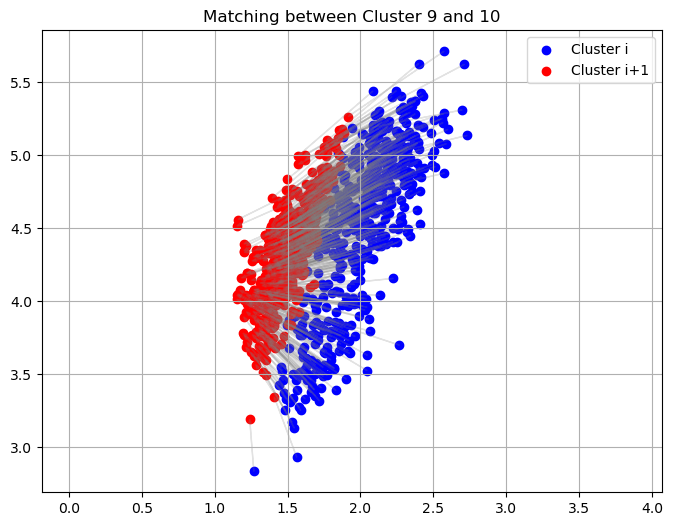

In [279]:
# Iterate through all consecutive pairs of clusters and plot the matchings
for i in range(len(sampled_points) - 1):
    plot_matchings(sampled_points[i], sampled_points[i + 1], matchings[i], title=f"Matching between Cluster {i + 1} and {i + 2}")

In [280]:
NN_training_dir

'/home/ubuntu22/Documents/PhD/oshea-j-wood-c-pbp-design-2023/../ensembleFolding/exp2_enzyme_preliminary/bin/32sims'

In [281]:
# save the clusters and matchings as .npy files
np.save(f"{NN_training_dir}/RMSD_cluster_labels.npy", cluster_labels)
np.save(f"{NN_training_dir}/RMSD_data.npy", x0s)
np.save(f"{NN_training_dir}/sampled_points.npy", sampled_points)
np.save(f"{NN_training_dir}/matchings.npy", matchings)

### After training, trying to visualise trajectories with real protein

generated_trajectories.shape=(25, 100, 2)
num_seeds=25, steps=100


/tmp/ipykernel_3540321/711403310.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


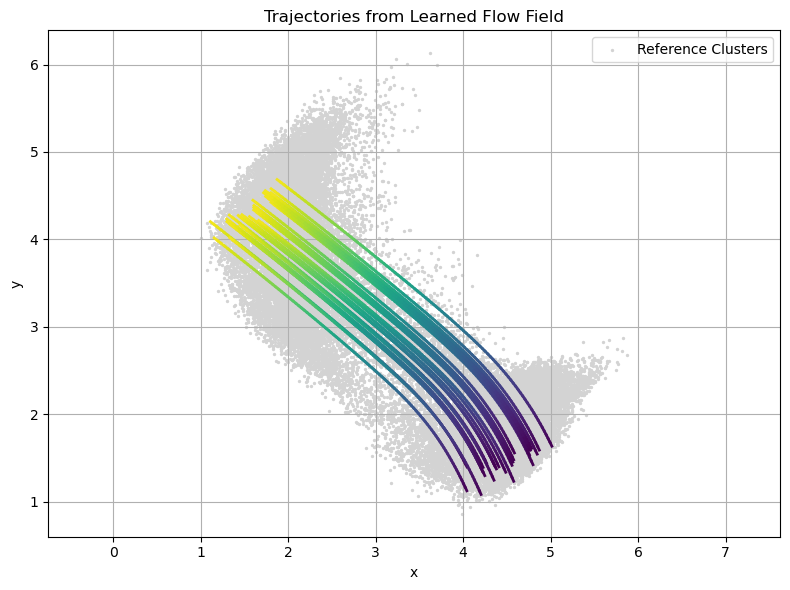

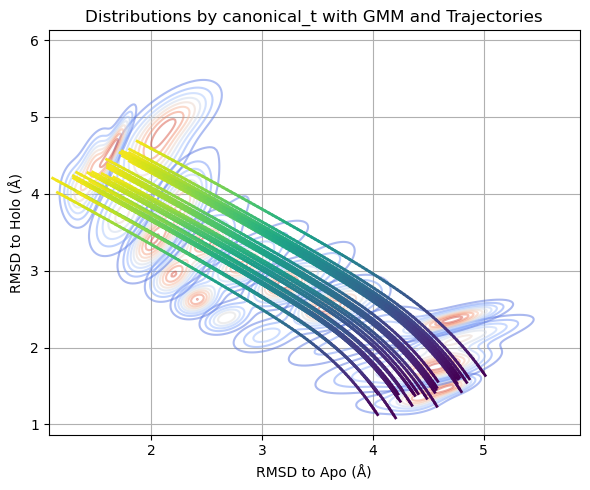

In [193]:
# load the trajectories
generated_trajectories = np.load(f"{NN_training_dir}/generated_trajectories.npy")
print(f"{generated_trajectories.shape=}")

# Plot raw data (all clusters)
plt.figure(figsize=(8, 6))
plt.scatter(x0s[:, 0], x0s[:, 1], color='lightgrey', s=2, label='Reference Clusters')

# Plot colored trajectories
import matplotlib.cm as cm
cmap = cm.get_cmap('viridis')
num_seeds, steps = generated_trajectories.shape[:2]
print(f"{num_seeds=}, {steps=}")
for i in range(num_seeds):
    traj = generated_trajectories[i]
    for j in range(steps - 1):
        plt.plot(traj[j:j+2, 0], traj[j:j+2, 1], color=cmap(j / steps), linewidth=2)

plt.title("Trajectories from Learned Flow Field")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(6, 5))
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
for cluster_idx in range(n_clusters):
    cluster_mask = (cluster_labels == cluster_idx)
    cluster_points = x0s[cluster_mask]
    
    # Create a grid for evaluating the Gaussian PDF
    x = np.linspace(cluster_points[:, 0].min(), cluster_points[:, 0].max(), 100)
    y = np.linspace(cluster_points[:, 1].min(), cluster_points[:, 1].max(), 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    
    if len(cluster_points) > 1:  # Ensure there are enough points to calculate mean and covariance
        # Fit a GMM with 2 Gaussians
        gmm = GaussianMixture(n_components=3, random_state=42, max_iter=1000)
        gmm.fit(cluster_points)
        
        marginal_distributions.append(gmm)
        
        # Evaluate the GMM for the cluster
        Z_cluster = np.exp(gmm.score_samples(pos.reshape(-1, 2))).reshape(X.shape)
        marginal_densities.append((X, Y, Z_cluster))

        # Plot the GMM as a contour
        plt.contour(X, Y, Z_cluster, levels=10, alpha=0.5, cmap='coolwarm')

for i in range(num_seeds):
    traj = generated_trajectories[i]
    for j in range(steps - 1):
        plt.plot(traj[j:j+2, 0], traj[j:j+2, 1], color=cmap(j / steps), linewidth=2)


plt.xlabel('RMSD to Apo (Å)')
plt.ylabel('RMSD to Holo (Å)')
plt.title('Distributions by canonical_t with GMM and Trajectories')
# plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

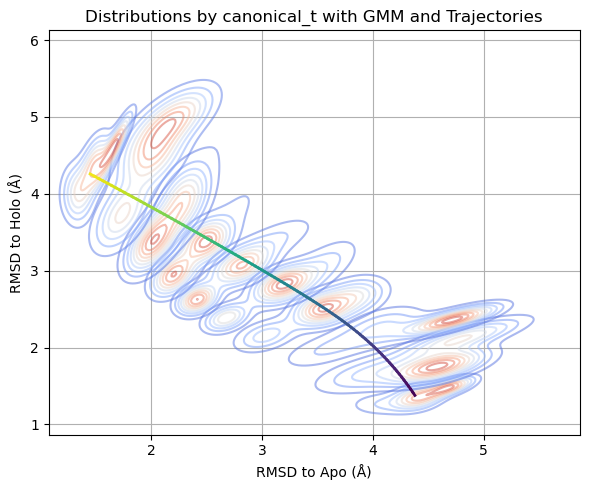

In [200]:
plt.figure(figsize=(6, 5))
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
for cluster_idx in range(n_clusters):
    cluster_mask = (cluster_labels == cluster_idx)
    cluster_points = x0s[cluster_mask]
    
    # Create a grid for evaluating the Gaussian PDF
    x = np.linspace(cluster_points[:, 0].min(), cluster_points[:, 0].max(), 100)
    y = np.linspace(cluster_points[:, 1].min(), cluster_points[:, 1].max(), 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    
    if len(cluster_points) > 1:  # Ensure there are enough points to calculate mean and covariance
        # Fit a GMM with 2 Gaussians
        gmm = GaussianMixture(n_components=3, random_state=42, max_iter=1000)
        gmm.fit(cluster_points)
        
        marginal_distributions.append(gmm)
        
        # Evaluate the GMM for the cluster
        Z_cluster = np.exp(gmm.score_samples(pos.reshape(-1, 2))).reshape(X.shape)
        marginal_densities.append((X, Y, Z_cluster))

        # Plot the GMM as a contour
        plt.contour(X, Y, Z_cluster, levels=10, alpha=0.5, cmap='coolwarm')

traj = generated_trajectories[6]
for j in range(steps - 1):
    plt.plot(traj[j:j+2, 0], traj[j:j+2, 1], color=cmap(j / steps), linewidth=2)


plt.xlabel('RMSD to Apo (Å)')
plt.ylabel('RMSD to Holo (Å)')
plt.title('Distributions by canonical_t with GMM and Trajectories')
# plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

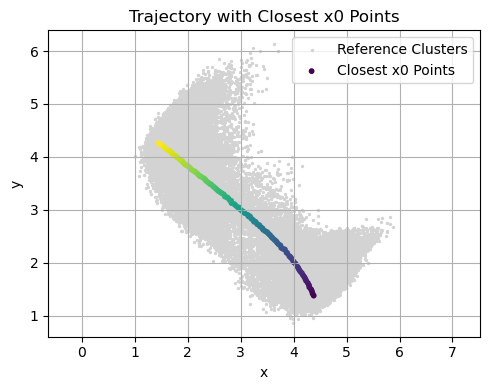

In [234]:
# given a traj, find the closest x0 indices
def find_closest_x0_indices(traj, x0s):
    distances = np.linalg.norm(traj[:, np.newaxis] - x0s, axis=2)
    closest_indices = np.argmin(distances, axis=1)
    return closest_indices

# Example usage
traj = generated_trajectories[6]
closest_indices = find_closest_x0_indices(traj, x0s)
# Plot the trajectory with closest x0 points
plt.figure(figsize=(5, 4))
plt.scatter(x0s[:, 0], x0s[:, 1], color='lightgrey', s=2, label='Reference Clusters')
# plt.plot(traj[:, 0], traj[:, 1], color='blue', linewidth=2, label='Trajectory')
# for j in range(len(traj) - 1):
#     plt.plot([traj[j, 0], x0s[closest_indices[j], 0]], [traj[j, 1], x0s[closest_indices[j], 1]], color='red', alpha=0.5)
# plt.scatter(x0s[closest_indices, 0], x0s[closest_indices, 1], color='red', s=10, label='Closest x0 Points')
colors = plt.cm.viridis(np.linspace(0, 1, len(traj)))
for j in range(len(traj) - 1):
    plt.plot([traj[j, 0], x0s[closest_indices[j], 0]], [traj[j, 1], x0s[closest_indices[j], 1]], color=colors[j], alpha=0.5)
plt.scatter(x0s[closest_indices, 0], x0s[closest_indices, 1], c=np.arange(len(closest_indices)), cmap='viridis', s=10, label='Closest x0 Points')
plt.title("Trajectory with Closest x0 Points")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [219]:
# as x0s flattens the data, convert indices back to (sim_id, frame_id)
# RMSD_apo_hol.shape  # (32, 1000, 2)
gen_traj_sim_id, gen_traj_frame_id = np.unravel_index(closest_indices, RMSD_apo_hol.shape[:2])
print(gen_traj_sim_id.shape, gen_traj_frame_id.shape)

(100,) (100,)


In [ ]:
from MDAnalysis.coordinates.DCD import DCDWriter

# according to the indices, load the corresponding dcd states and save trajectory as a new dcd file
# Define the output DCD file path
output_dcd_path = f"Simulations/Apo/trained_model/generated_trajectory.dcd"

# Load the topology file
apo_top = "Simulations/Apo/1anf_malremoved_t3p.parm7"

# Create a DCD writer
with DCDWriter(output_dcd_path, n_atoms=results[sims[0]]['protein_atoms_traj_apo'].universe.atoms.n_atoms) as writer:
    for sim_id, frame_id in zip(gen_traj_sim_id, gen_traj_frame_id):
        # Load the corresponding simulation trajectory
        apo_dcd = f"Simulations/Apo/simulation_{sim_id:02d}/npt_production_{sim_id:02d}.dcd"
        u = mda.Universe(apo_top, apo_dcd)
        
        # Set the trajectory to the specific frame
        u.trajectory[frame_id]
        
        # Write all atom positions to the new DCD file
        writer.write(u.atoms)


In [228]:
# Align the protein in the generated trajectory
aligned_dcd_path = f"Simulations/Apo/trained_model/aligned_generated_trajectory.dcd"

# Load the generated trajectory
u_generated = mda.Universe(apo_top, output_dcd_path)

# select the first frame as the reference
u.trajectory[0]
ref_frame = u_generated.atoms.select_atoms("protein and name CA")

# align the output_dcd_path trajectory to the reference frame
align.AlignTraj(u_generated, ref_frame, select="protein and name CA", in_memory=True).run()

# with DCDWriter(aligned_dcd_path, n_atoms=u_generated.select_atoms("protein").n_atoms) as writer:
#     for ts in u_generated.trajectory:
#         writer.write(u_generated.select_atoms("protein"))
        
# save the first frame of the aligned trajectory as a PDB file
pdb_path = f"Simulations/Apo/trained_model/aligned_generated_trajectory_first_frame.pdb"
with mda.Writer(pdb_path, n_atoms=u_generated.select_atoms("protein").n_atoms) as writer:
    u_generated.trajectory[0]
    writer.write(u_generated.select_atoms("protein"))
    
# save the final frame of the aligned trajectory as a PDB file
pdb_path = f"Simulations/Apo/trained_model/aligned_generated_trajectory_final_frame.pdb"
with mda.Writer(pdb_path, n_atoms=u_generated.select_atoms("protein").n_atoms) as writer:
    u_generated.trajectory[-1]
    writer.write(u_generated.select_atoms("protein"))



/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/ubuntu22/miniconda3/envs/md/lib/python3.10

In [114]:
len(results)

33

In [115]:
Xtraj_all.shape

(32, 1000, 1110)

In [134]:
import numpy as np
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout


# Define a function to calculate energy using OpenMM
def calculate_energy_openmm(top_path, coord_path):
    # with implicit solvent
    print("Loading amber files...")
    prmtop = AmberPrmtopFile(str(top_path))
    inpcrd = AmberInpcrdFile(str(coord_path))
    print("Loading amber files... Done.")

    # Keep only protein atoms
    print("Stripping non-protein residues...")
    modeller = Modeller(prmtop.topology, inpcrd.positions)
    
    # Keep only standard amino acids (3-letter codes)
    standard_resnames = {
        "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY",
        "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER",
        "THR", "TRP", "TYR", "VAL"
    }
    non_protein_residues = [
        res for res in modeller.topology.residues()
        if res.name.upper() not in standard_resnames
    ]

    modeller.delete(non_protein_residues)
    print(f"New topology has {modeller.topology.getNumAtoms()} atoms")

    print("Creating system...")
    forcefield = ForceField('amber14-all.xml', 'implicit/gbn2.xml')
    system = forcefield.createSystem(modeller.topology, soluteDielectric=1.0, solventDielectric=80.0)
    # forcefield = ForceField('amoeba2009.xml', 'amoeba2009_gk.xml')
    # system = forcefield.createSystem(modeller.topology, nonbondedMethod=NoCutoff, constraints=None, rigidWater=False)
    # forcefield = ForceField("amber14-all.xml", "amber14-obc.xml")
    # system = forcefield.createSystem(  # use ForceField if available
    #     modeller.topology,
    #     nonbondedMethod=PME,
    #     nonbondedCutoff=1*nanometer,
    #     constraints=HBonds,
    # )
    # system = prmtop.createSystem(nonbondedMethod=PME, nonbondedCutoff=1 * nanometer, constraints=HBonds)
    # system.addForce(MonteCarloBarostat(1 * unit.bar, 300 * unit.kelvin))

    integrator = LangevinIntegrator(300 * kelvin, 1 / picosecond, 2 * femtosecond)
    platform = Platform.getPlatformByName("CUDA")

    simulation = Simulation(modeller.topology, system, integrator, platform)
    simulation.context.setPositions(modeller.positions)

    if inpcrd.boxVectors is not None:
        simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

    print(f"Final topology has {modeller.topology.getNumAtoms()} atoms")
    
    # with explicit solvent
    # system = prmtop.createSystem(
    #     nonbondedMethod=PME, nonbondedCutoff=1 * nanometer, constraints=HBonds
    # )
    # system.addForce(MonteCarloBarostat(1 * bar, 300 * kelvin))
    # integrator = LangevinIntegrator(300 * kelvin, 1 / picosecond, 2 * femtosecond)
    # platform = Platform.getPlatformByName("CUDA")
    # simulation = Simulation(prmtop.topology, system, integrator, platform)
    # simulation.context.setPositions(inpcrd.positions)
    # if inpcrd.boxVectors is not None:
    #     simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)
    # print(f"Topology shape: {prmtop.topology.getNumAtoms()} atoms")

    energies = []
    
    for sim in sims:
        print(f"Loading simulation {sim}...")
        # Load the trajectory
        apo_dcd = f"Simulations/Apo/simulation_{sim:02d}/npt_production_{sim:02d}.dcd"
        
        u = mda.Universe(top_path, apo_dcd)
        
        protein = u.select_atoms("protein")
        
        energy_sim = []
        for ts in u.trajectory:
            positions = protein.positions  # Use all atom positions
            assert positions.shape == (modeller.topology.getNumAtoms(), 3), f"Expected {modeller.topology.getNumAtoms()} atoms, got {positions.shape[0]} atoms"
            simulation.context.setPositions(positions * nanometer)
            state_energy = simulation.context.getState(getEnergy=True).getPotentialEnergy()
            energy_sim.append(state_energy.value_in_unit(kilojoule_per_mole))
            print(state_energy)
        
        energies.append(energy_sim)
    
    return np.array(energies)

# Calculate the energy for each state in x0s
k = 1.0  # Spring constant
x0_equilibrium = np.zeros(x0s.shape[1])  # Equilibrium position
root_path = "Simulations/Apo/"
energies = calculate_energy_openmm(top_path=root_path+"1anf_malremoved_t3p.parm7", 
    coord_path=root_path+"1anf_malremoved_t3p.rst7")

# Print the calculated energies
print("Energies for each state:", energies)

Loading amber files...
Loading amber files... Done.
Stripping non-protein residues...
New topology has 5737 atoms
Creating system...
Final topology has 5737 atoms
Loading simulation 32...
1202314982.2321777 kJ/mol
1202588713.7214355 kJ/mol
1204316619.1699219 kJ/mol
1202907126.4831543 kJ/mol
1202868038.2341309 kJ/mol
1202971987.1542969 kJ/mol
1202644176.27417 kJ/mol
1203111607.1879883 kJ/mol
1202483241.8666992 kJ/mol
1202892889.1860352 kJ/mol
1203609209.3078613 kJ/mol
1202221110.84375 kJ/mol
1204477171.5483398 kJ/mol
1202286392.0737305 kJ/mol
1203029195.121582 kJ/mol
1203240798.683838 kJ/mol
1203742846.538086 kJ/mol
1202912561.1315918 kJ/mol
1203764609.8833008 kJ/mol
1203418766.104248 kJ/mol
1202795976.0932617 kJ/mol
1202310104.3061523 kJ/mol
1202907848.0998535 kJ/mol
1203656979.21875 kJ/mol
1202599097.2460938 kJ/mol
1203369314.5595703 kJ/mol
1202870969.0839844 kJ/mol
1203287059.1887207 kJ/mol
1204200221.5546875 kJ/mol
1203488782.7216797 kJ/mol
1203385818.31958 kJ/mol
1203620143.8950195

In [ ]:
energies.shape

(32, 1000)

In [123]:
x0s.shape

(32000, 2)

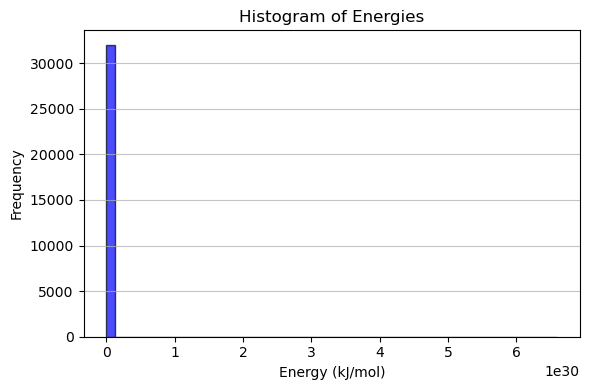

In [124]:
plt.figure(figsize=(6, 4))
plt.hist(energies.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Energy (kJ/mol)')
plt.ylabel('Frequency')
plt.title('Histogram of Energies')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

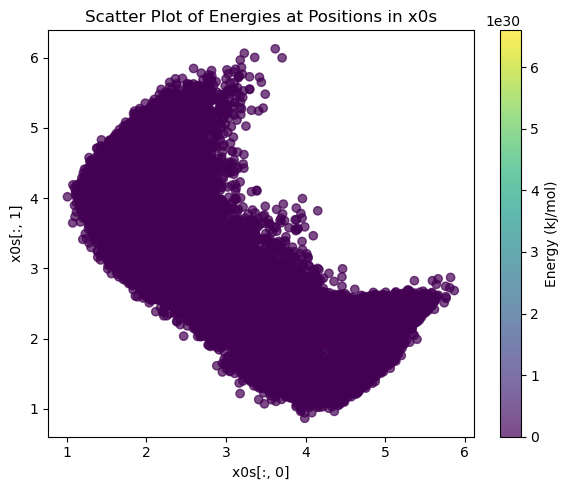

In [120]:
plt.figure(figsize=(6, 5))
scatter = plt.scatter(x0s[:, 0], x0s[:, 1], c=energies.flatten(), cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Energy (kJ/mol)')
plt.xlabel('x0s[:, 0]')
plt.ylabel('x0s[:, 1]')
plt.title('Scatter Plot of Energies at Positions in x0s')
plt.tight_layout()
plt.show()


Relative Boltzmann energies (Delta G): [0.56748617 0.90474921 0.35506647 ... 0.31796093 0.41837454 0.40977075]


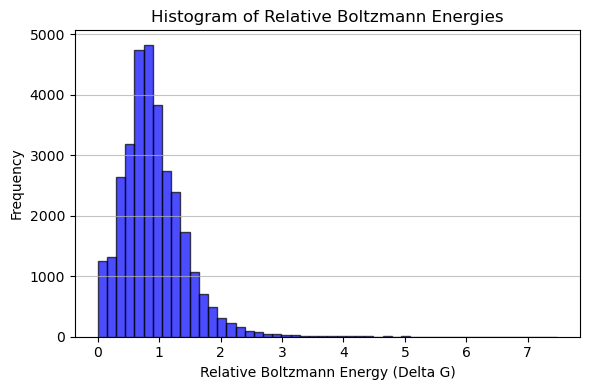

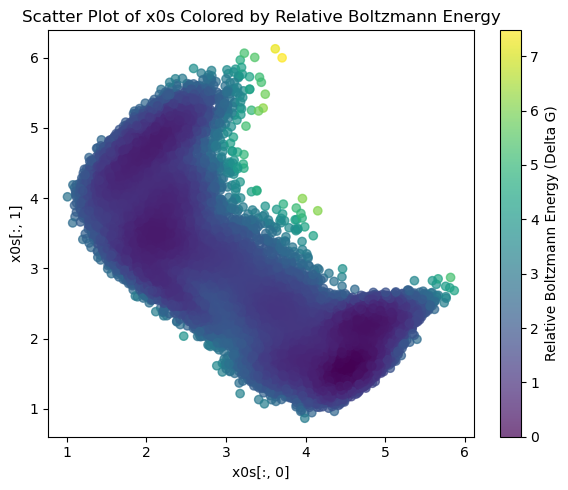

In [139]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Constants
k_b = 0.0019872041  # Boltzmann constant in kcal/(mol*K)
T = 300  # Temperature in Kelvin

# Fit a GMM to x0s
n_components = 10  # Number of Gaussian components
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(x0s)

# Calculate the log probabilities for each point in x0s
log_prob = gmm.score_samples(x0s)

# Convert log probabilities to relative Boltzmann energy
delta_G = -k_b * T * log_prob

# Normalize the energies to set the minimum energy to zero
delta_G -= np.min(delta_G)

# Print the results
print("Relative Boltzmann energies (Delta G):", delta_G)

# Plot the relative Boltzmann energies
plt.figure(figsize=(6, 4))
plt.hist(delta_G, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Relative Boltzmann Energy (Delta G)')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Boltzmann Energies')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

# Scatter plot of x0s colored by relative Boltzmann energy
plt.figure(figsize=(6, 5))
scatter = plt.scatter(x0s[:, 0], x0s[:, 1], c=delta_G, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Relative Boltzmann Energy (Delta G)')
plt.xlabel('x0s[:, 0]')
plt.ylabel('x0s[:, 1]')
plt.title('Scatter Plot of x0s Colored by Relative Boltzmann Energy')
plt.tight_layout()
plt.show()

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.

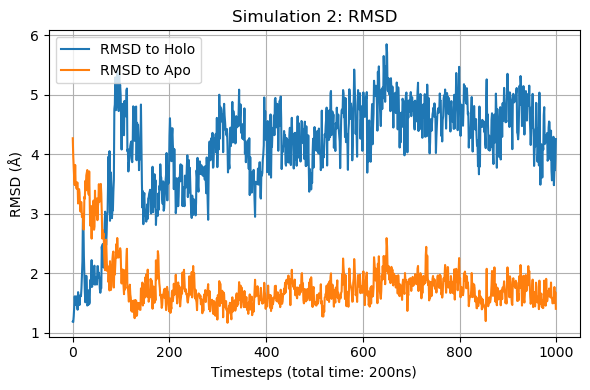

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


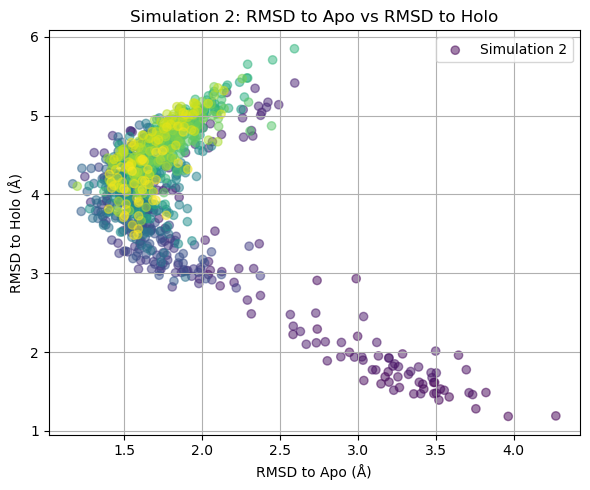

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


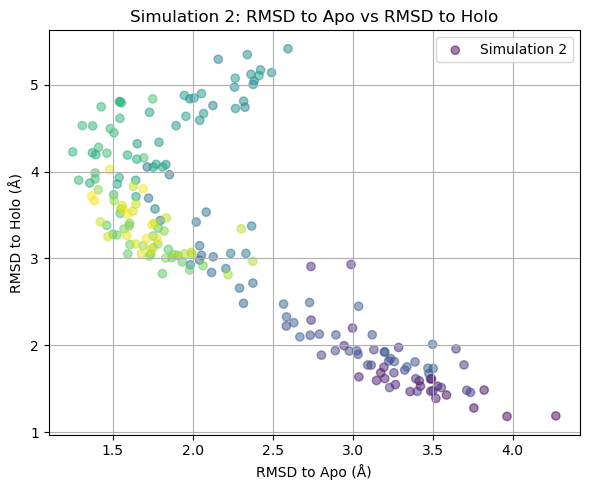

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.

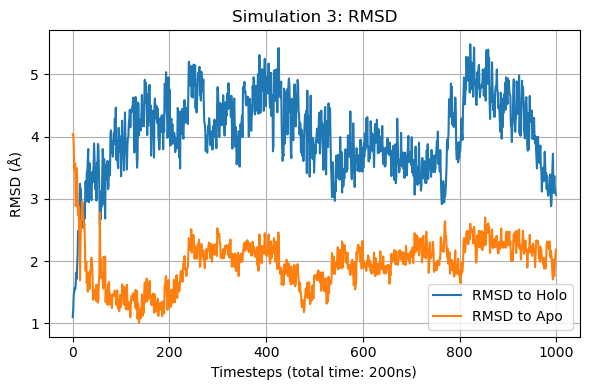

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


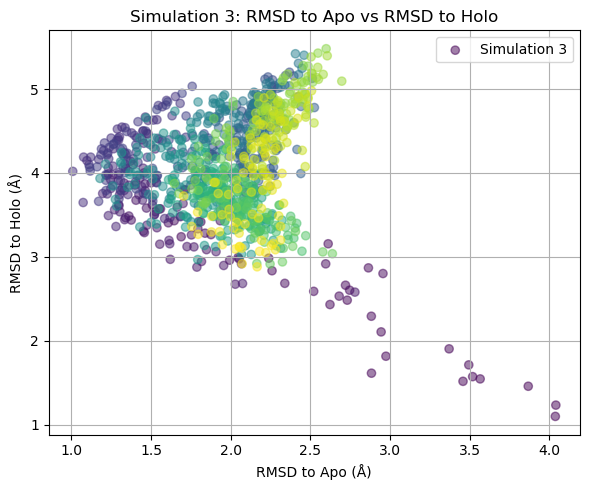

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


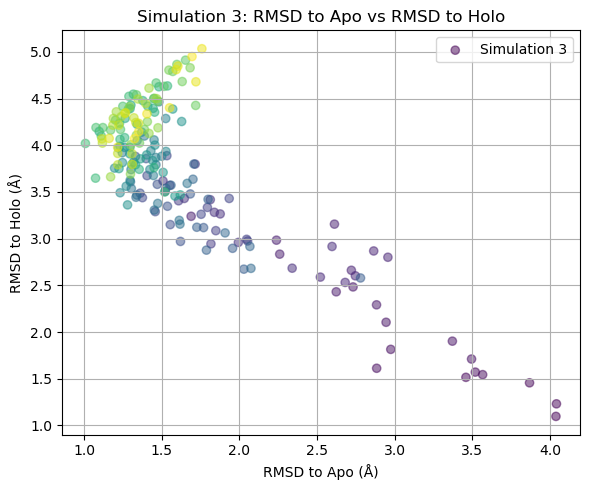

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.

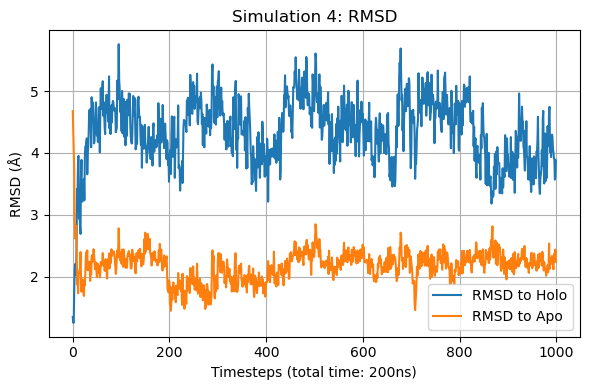

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


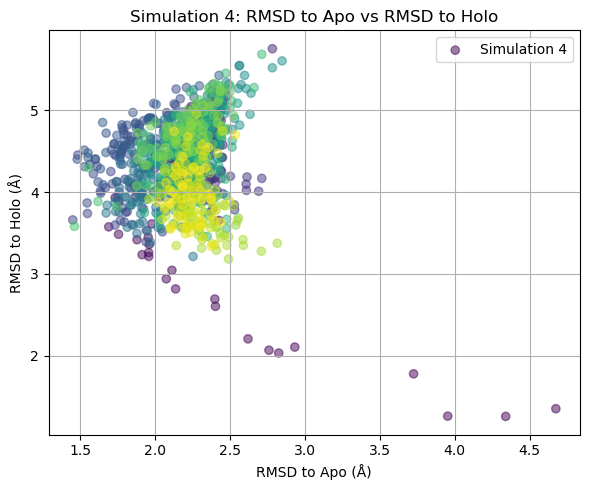

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


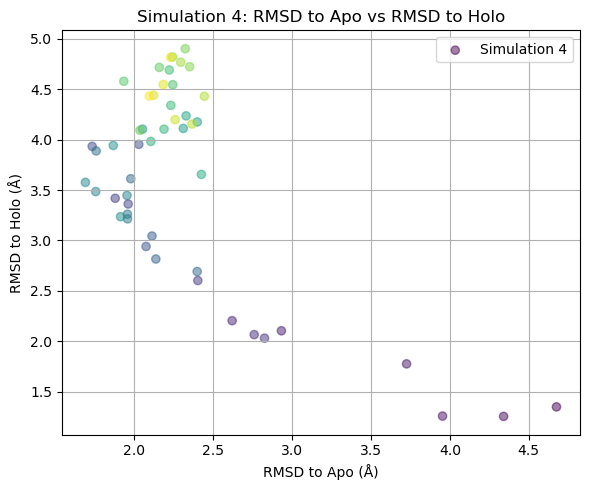

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.

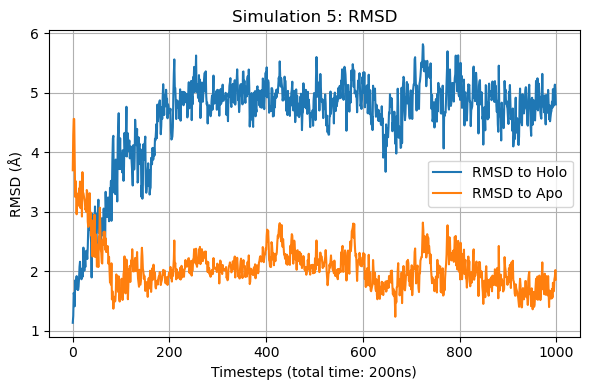

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


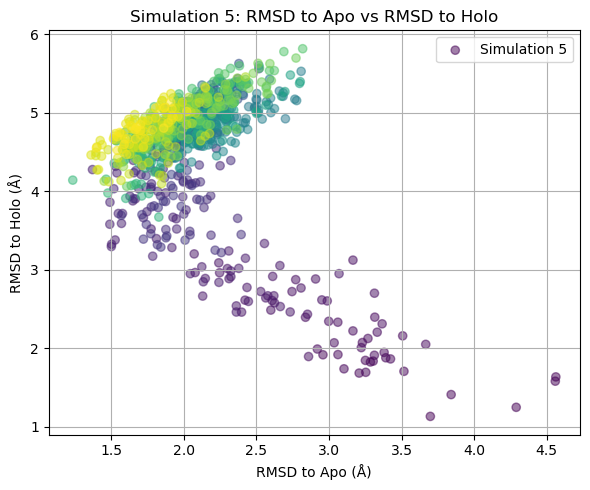

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


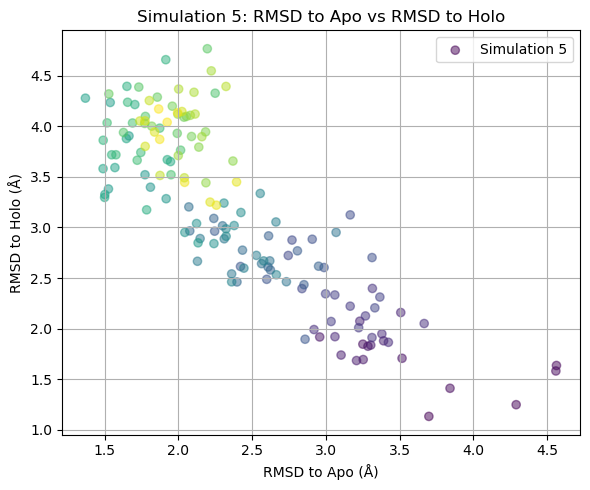

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.

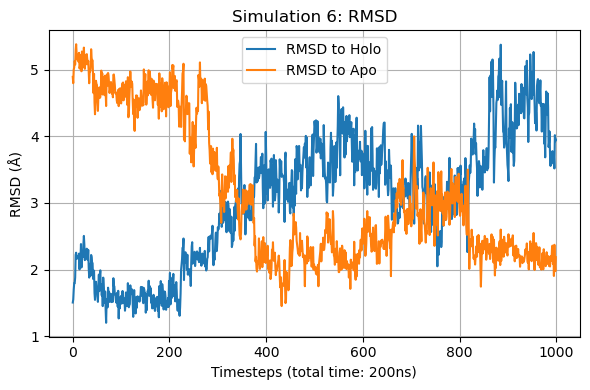

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


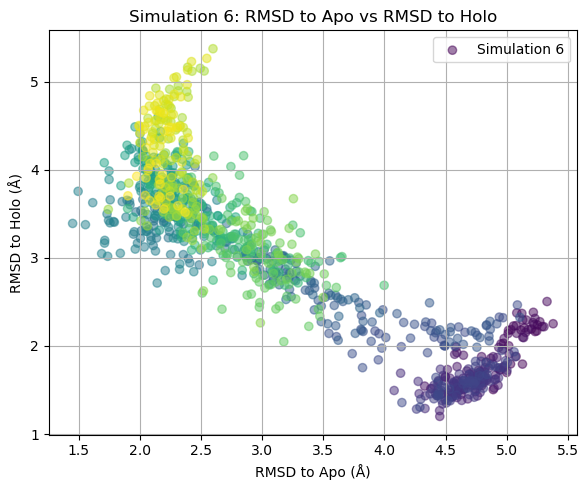

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


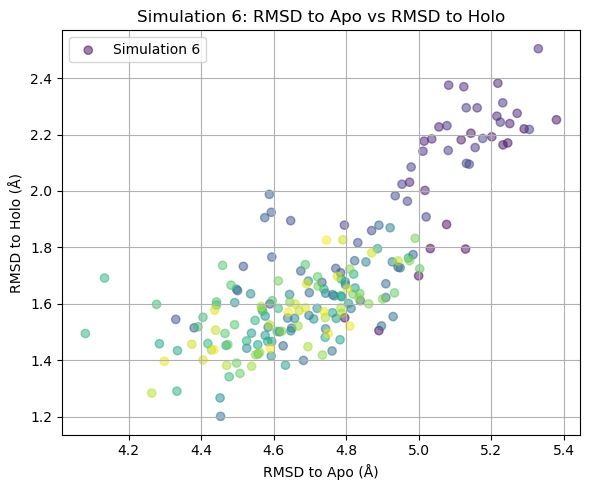

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.

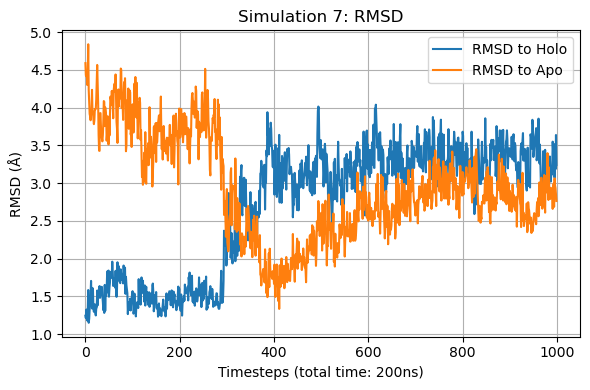

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


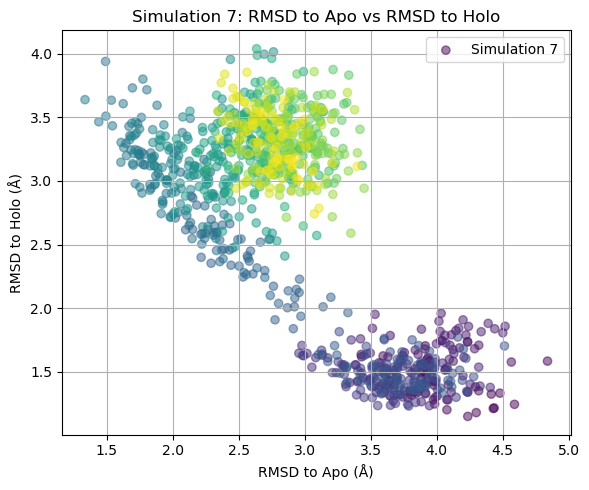

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


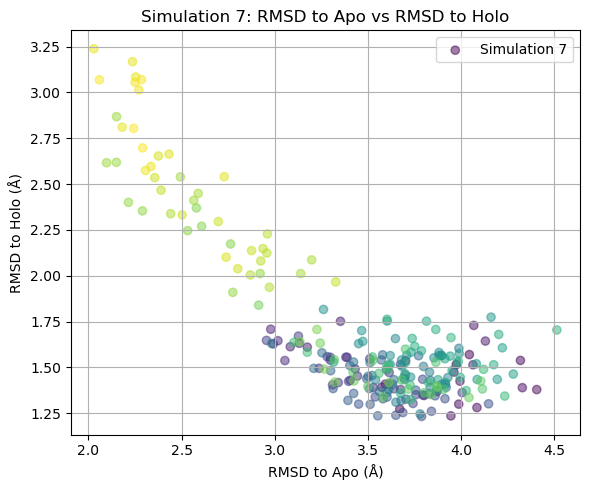

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.

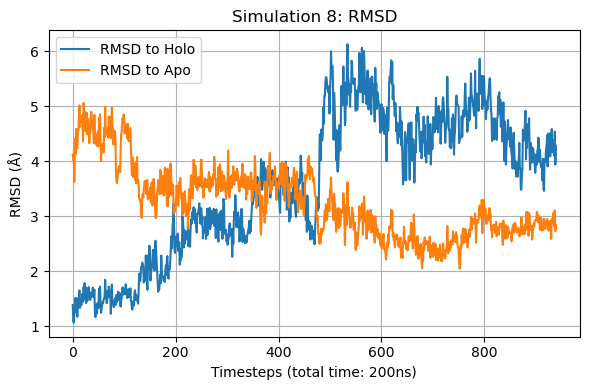

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


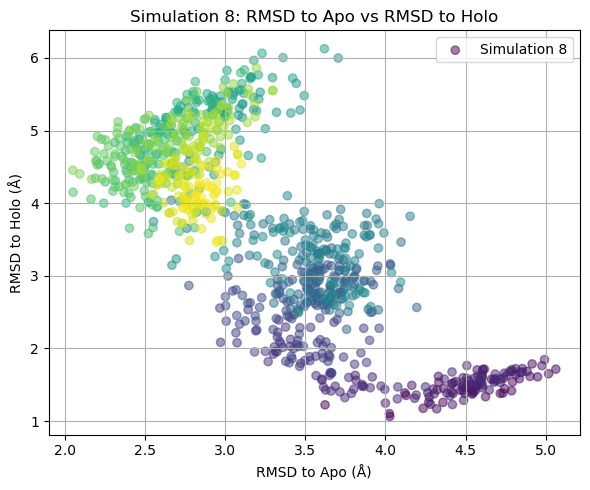

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


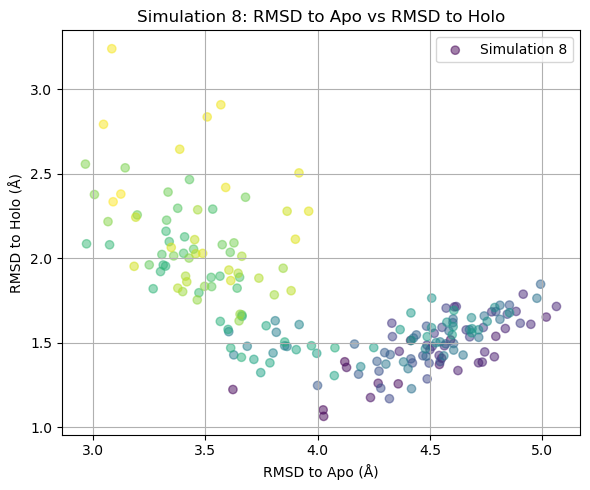

In [58]:
sims = range(1, 9)

sims = [(2, 0, 200), (3, 0, 200), (4, 0, 50), (5, 0, 150), (6, 0, 200), (7, 100, 340), (8, 0, 200)]

results = {}

for sim, t0, t1 in sims:
    apo_top = "Simulations/Apo/1anf_malremoved_t3p.parm7"
    apo_dcd = f"Simulations/Apo/simulation_{sim:02d}/npt_production_{sim:02d}.dcd"    
    hol_top = "Simulations/Holo/1anf_mal_t3p.parm7"
    hol_dcd = f"Simulations/Holo/simulation_{sim:02d}/npt_production_{sim:02d}.dcd"

    apo_crystal = f"{os.getcwd()}/Simulations/Apo/1anf_malremoved_tleap.pdb"  # Replace with the actual path to the apo crystal structure
    hol_crystal = f"{os.getcwd()}/Simulations/Holo/1omp.pdb"  # Replace with the actual path to the apo crystal structure

    # Load the apo trajectory
    u = mda.Universe(apo_top, apo_dcd)

    average = align.AverageStructure(u, u, select='protein and name CA', ref_frame=0).run()
    ref = average.results.universe

    # Load the apo crystal structure
    u_crystal_apo = mda.Universe(apo_crystal)

    # Load the holo crystal structure
    u_crystal_hol = mda.Universe(hol_crystal)

    # Align the apo crystal structure to the reference
    align.AlignTraj(u_crystal_apo, ref, select='protein and name CA', in_memory=True).run()

    # Align the holo crystal structure to the reference
    align.AlignTraj(u_crystal_hol, ref, select='protein and name CA', in_memory=True).run()

    # Select the protein atoms in the apo trajectory and the apo crystal structure
    protein_atoms_traj_apo = u.select_atoms('protein and name CA')
    protein_atoms_crystal_apo = u_crystal_apo.select_atoms('protein and name CA')

    # Select the protein atoms in the holo trajectory and the holo crystal structure
    protein_atoms_crystal_hol = u_crystal_hol.select_atoms('protein and name CA')

    # Calculate RMSD for apo
    RMSD_hol = rms.RMSD(protein_atoms_traj_apo, protein_atoms_crystal_apo).run()

    # Calculate RMSD for holo
    RMSD_apo = rms.RMSD(protein_atoms_traj_apo, protein_atoms_crystal_hol).run()

    # Extract timeseries data using the `.timeseries()` method
    # Shape: (num_frames, num_CA_atoms, 3)
    uptoIdx = np.ceil(200 / 200 * u.trajectory.n_frames).astype(int)
    Xtraj = np.empty((uptoIdx, protein_atoms_traj_apo.n_atoms, 3))

    # Iterate over the entire trajectory and store Cα positions
    for i, y_clustered in enumerate(u.trajectory[:uptoIdx]):
        Xtraj[i] = protein_atoms_traj_apo.positions  # Store positions of Cα atoms

    # Store results in the dictionary
    results[sim] = {
        'RMSD_apo': RMSD_apo,
        'RMSD_hol': RMSD_hol,
        'protein_atoms_traj_apo': protein_atoms_traj_apo,
        'protein_atoms_crystal_apo': protein_atoms_crystal_apo,
        'protein_atoms_crystal_hol': protein_atoms_crystal_hol,
        'Xtraj': Xtraj
    }

    # Plot RMSD against time for both apo and holo
    plt.figure(figsize=(6, 4))
    plt.plot(RMSD_hol.rmsd[:, 2], label=f'RMSD to Holo')
    plt.plot(RMSD_apo.rmsd[:, 2], label=f'RMSD to Apo')
    plt.xlabel('Timesteps (total time: 200ns)')
    plt.ylabel('RMSD (Å)')
    plt.title(f'Simulation {sim}: RMSD')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"{os.getcwd()}/Simulations/Apo/simulation_{sim:02d}/RMSD_{sim}.png")
    plt.savefig(f"{os.getcwd()}/Simulations/Apo/simulation_{sim:02d}/RMSD_{sim}.pdf")
    plt.savefig(f"{NN_training_dir}/RMSD_to_closed_{sim}.png")
    plt.savefig(f"{NN_training_dir}/RMSD_to_closed_{sim}.pdf")
    plt.show()
    
    # Scatter plot: RMSD to Apo vs RMSD to Holo
    plt.figure(figsize=(6, 5))
    plt.scatter(RMSD_apo.rmsd[:, 2], RMSD_hol.rmsd[:, 2], c=np.arange(len(RMSD_apo.rmsd[:, 2])), cmap='viridis', alpha=0.5, label=f'Simulation {sim}')
    plt.xlabel('RMSD to Apo (Å)')
    plt.ylabel('RMSD to Holo (Å)')
    plt.title(f'Simulation {sim}: RMSD to Apo vs RMSD to Holo')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"{os.getcwd()}/Simulations/Apo/simulation_{sim:02d}/RMSD_scatter_{sim}.png")
    plt.savefig(f"{os.getcwd()}/Simulations/Apo/simulation_{sim:02d}/RMSD_scatter_{sim}.pdf")
    plt.savefig(f"{NN_training_dir}/RMSD_scatter_{sim}.png")
    plt.savefig(f"{NN_training_dir}/RMSD_scatter_{sim}.pdf")
    plt.show()
    
    # Scatter plot: RMSD to Apo vs RMSD to Holo
    plt.figure(figsize=(6, 5))
    plt.scatter(RMSD_apo.rmsd[t0:t1, 2], RMSD_hol.rmsd[t0:t1, 2], c=np.arange(len(RMSD_apo.rmsd[t0:t1, 2])), cmap='viridis', alpha=0.5, label=f'Simulation {sim}')
    plt.xlabel('RMSD to Apo (Å)')
    plt.ylabel('RMSD to Holo (Å)')
    plt.title(f'Simulation {sim}: RMSD to Apo vs RMSD to Holo')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"{os.getcwd()}/Simulations/Apo/simulation_{sim:02d}/RMSD_scatter_{sim}.png")
    plt.savefig(f"{os.getcwd()}/Simulations/Apo/simulation_{sim:02d}/RMSD_scatter_{sim}.pdf")
    plt.savefig(f"{NN_training_dir}/RMSD_scatter_{sim}.png")
    plt.savefig(f"{NN_training_dir}/RMSD_scatter_{sim}.pdf")
    plt.show()


# # Concatenate RMSD data across all simulations data across all simulations
# RMSD_apo_all = np.vstack([results[sim]['RMSD_apo'].rmsd[:, 2] for sim in sims[1:-1]])
# RMSD_hol_all = np.vstack([results[sim]['RMSD_hol'].rmsd[:, 2] for sim in sims[1:-1]])

# # Scatter plot: RMSD to Apo vs RMSD to Holo for all simulationsations
# plt.figure(figsize=(6, 5))
# for idx, (rmsd_apo, rmsd_hol) in enumerate(zip(RMSD_apo_all, RMSD_hol_all)):
#     plt.scatter(rmsd_apo, rmsd_hol, c=np.arange(len(rmsd_apo)), cmap='viridis', alpha=0.5)
# plt.xlabel('RMSD to Apo (Å)')
# plt.ylabel('RMSD to Holo (Å)')
# plt.title('RMSD to Apo vs RMSD to Holo (All Simulations)')
# plt.grid()
# plt.tight_layout()
# plt.colorbar(label='Simulation Timeframe (0~200ns)')
# plt.savefig(f"{NN_training_dir}/RMSD_scatter_all_sims.png")
# plt.savefig(f"{NN_training_dir}/RMSD_scatter_all_sims.pdf")
# plt.show()


RMSD to Hol: (7520,)
Max RMSD to Holo: 6.127659227014363
Min RMSD to Holo: 1.064075497042819


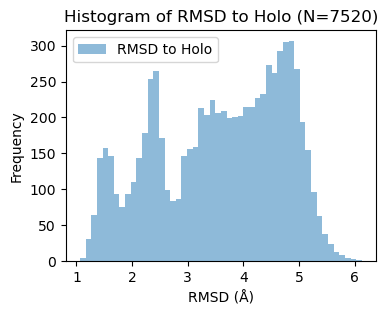

In [20]:

# concate the data for all simulations, and plot the histogram
RMSD_hol_values = np.concatenate([results[sim]['RMSD_hol'].results.rmsd[:uptoIdx, 2] for sim in sims])

print("RMSD to Hol:", RMSD_hol_values.shape)
print("Max RMSD to Holo:", np.max(RMSD_hol_values))
print("Min RMSD to Holo:", np.min(RMSD_hol_values))

plt.figure(figsize=(4, 3))
plt.hist(RMSD_hol_values, bins=50, alpha=0.5, label=f'RMSD to Holo')
plt.xlabel('RMSD (Å)')
plt.ylabel('Frequency')
plt.title(f'Histogram of RMSD to Holo (N={len(RMSD_hol_values)})')
plt.legend()
plt.savefig(f"{NN_training_dir}/RMSD_histogram.png")
plt.savefig(f"{NN_training_dir}/RMSD_histogram.pdf")
plt.show()


Number of CA atoms: 370
Dim: 1110
All positions are different: True
RMSD to Hol: (7520,)
Max RMSD to Holo: 6.127659227014363
Min RMSD to Holo: 1.064075497042819


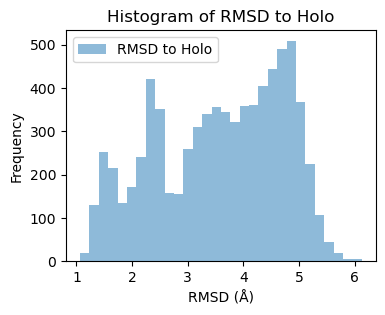

Cluster 1: (-inf, 2.8) (2127, 370, 3)
Cluster 2: (2.8, 4.2) (2619, 370, 3)
Cluster 3: (4.2, inf) (2774, 370, 3)


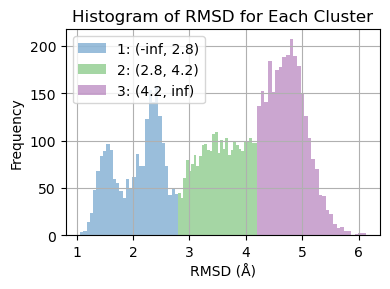

Reversed and Normalised cluster centers: [0.  0.5 1. ]
Cluster 1: 0.00 (2127, 370, 3) Mean RMSD to Apo: 2.07
Cluster 2: 0.50 (2619, 370, 3) Mean RMSD to Apo: 3.55
Cluster 3: 1.00 (2774, 370, 3) Mean RMSD to Apo: 4.76


In [21]:

# Concatenate the data for all simulations
Xtraj_all = np.concatenate([results[sim]['Xtraj'] for sim in sims], axis=0)
ca_atoms = u.select_atoms('protein and name CA')
print("Number of CA atoms:", len(ca_atoms))
print(f"Dim: {ca_atoms.n_atoms*3}")

# Reshape the concatenated data
Xtraj_all = Xtraj_all.reshape(-1, ca_atoms.n_atoms, 3)
    
# Check if all positions are different
all_positions_different = (np.diff(Xtraj_all, axis=0) == 0).any()
print(f"All positions are different: {all_positions_different}")



RMSDs_all = np.concatenate([results[sim]['RMSD_hol'].results.rmsd[:uptoIdx, 2] for sim in sims])

print("RMSD to Hol:", RMSDs_all.shape)
print("Max RMSD to Holo:", np.max(RMSDs_all))
print("Min RMSD to Holo:", np.min(RMSDs_all))

plt.figure(figsize=(4, 3))
plt.hist(RMSDs_all, bins=30, alpha=0.5, label='RMSD to Holo')
plt.xlabel('RMSD (Å)')
plt.ylabel('Frequency')
plt.title('Histogram of RMSD to Holo')
plt.legend()
plt.show()


# Use a specified cluster ranges to divide data into n_clusters
clusters = [(-float('inf'), 2.8), (2.8, 4.2), (4.2, float('inf'))]
n_clusters = len(clusters)
window_size = 0.8
y_clustered = []  # stores the cluster centers
X_clustered = []
RMSD_clustered = []


for i in range(n_clusters):
    lb, ub = clusters[i]
    x_ids = np.where((RMSDs_all >= lb) & (RMSDs_all <= ub))[0]
    
    data = Xtraj_all[x_ids]
    X_clustered.append(data)
    y_clustered.append(i)
    RMSD_clustered.append(RMSDs_all[x_ids])
    print(f"Cluster {i+1}: {(lb, ub)} {data.shape}")

y_clustered = np.array(y_clustered)
y_clustered = y_clustered / y_clustered.max()


# Plot histogram for each cluster with different colors
colors = plt.get_cmap('Set1').colors[1:]

plt.figure(figsize=(4, 3))
for i, (data, color) in enumerate(zip(RMSD_clustered, colors[:n_clusters])):
    plt.hist(data, bins=30, alpha=0.5, label=f'{i+1}: {clusters[i]}', color=color)
plt.xlabel('RMSD (Å)')
plt.ylabel('Frequency')
plt.title('Histogram of RMSD for Each Cluster')
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig(f"{NN_training_dir}/RMSD_histogram_clusters.png")
plt.savefig(f"{NN_training_dir}/RMSD_histogram_clusters.pdf")
plt.show()

print("Reversed and Normalised cluster centers:", y_clustered)
for i in range(len(X_clustered)):
    print(f"Cluster {i+1}: {y_clustered[i]:.2f} {X_clustered[i].shape} Mean RMSD to Apo: {np.mean(RMSD_clustered[i]):.2f}")


In [22]:
[X_clustered[i].shape[0] for i in range(len(X_clustered))]

[2127, 2619, 2774]

In [23]:
cluster_ranges = [X_clustered[i].shape[0] for i in range(len(X_clustered))]
cluster_ranges.insert(0, 0)
np.cumsum(cluster_ranges)

array([   0, 2127, 4746, 7520])

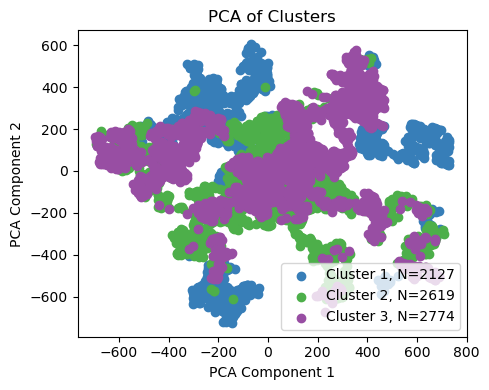

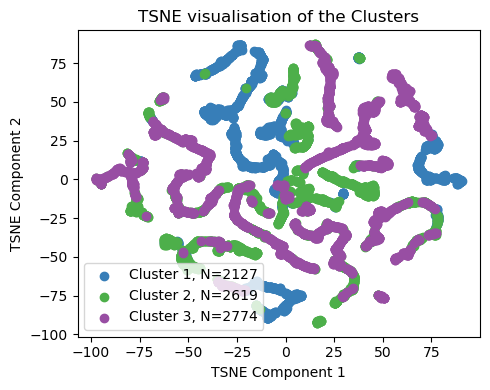

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Flatten the entire dataset for PCA and TSNE
X_MDS_visualisation = np.concatenate(X_clustered, axis=0)
X_MDS_visualisation = X_MDS_visualisation.reshape(len(X_MDS_visualisation), -1)

# Perform PCA on the entire dataset
pca_all = PCA(n_components=2)
X_pca_all = pca_all.fit_transform(X_MDS_visualisation)

# Perform TSNE on the entire dataset
tsne_all = TSNE(n_components=2, random_state=42)
X_tsne_all = tsne_all.fit_transform(X_MDS_visualisation)

N_cluster = [X_clustered[i].shape[0] for i in range(len(X_clustered))]
N_cluster.insert(0, 0)
cluster_ranges = np.cumsum(N_cluster)

# Plot PCA results for each cluster
plt.figure(figsize=(5, 4))
for i in range(n_clusters):
    plt.scatter(X_pca_all[cluster_ranges[i]:cluster_ranges[i+1], 0], X_pca_all[cluster_ranges[i]:cluster_ranges[i+1], 1], color=colors[i], label=f'Cluster {i+1}, N={len(X_clustered[i])}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Clusters')
plt.tight_layout()
plt.legend()
plt.savefig(f"{NN_training_dir}/PCA_clusters.png")
plt.savefig(f"{NN_training_dir}/PCA_clusters.pdf")
plt.show()

# Plot TSNE results for each cluster
plt.figure(figsize=(5, 4))
for i in range(n_clusters):
    plt.scatter(X_tsne_all[cluster_ranges[i]:cluster_ranges[i+1], 0], X_tsne_all[cluster_ranges[i]:cluster_ranges[i+1], 1], color=colors[i], label=f'Cluster {i+1}, N={len(X_clustered[i])}')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE visualisation of the Clusters')
plt.tight_layout()
plt.legend()
plt.savefig(f"{NN_training_dir}/TSNE_clusters.png")
plt.savefig(f"{NN_training_dir}/TSNE_clusters.pdf")
plt.show()


In [25]:
# save the cluster data

# NN_training_dir = f"{os.getcwd()}/../ensembleFolding/exp2_enzyme_preliminary/bin/5sims"

# Create directories if they do not exist
os.makedirs(NN_training_dir, exist_ok=True)

for i, x in enumerate(X_clustered):
    np.save(f"{NN_training_dir}/cluster_{i+1}.npy", x)
for i, x in enumerate(RMSD_clustered):
    np.save(f"{NN_training_dir}/cluster_RMSD_{i+1}.npy", x)
np.save(f"{NN_training_dir}/cluster_centers.npy", y_clustered)

In [26]:
total_data_points = sum([x.shape[0] for x in X_clustered])
print(f"Total number of data points in X_clustered: {total_data_points}")

Total number of data points in X_clustered: 7520


In [27]:
# Save the 2D clusters after PCA

# Plot PCA results for each cluster
for i in range(n_clusters):
    np.save(f"{NN_training_dir}/PCA_cluster_{i+1}.npy", X_pca_all[cluster_ranges[i]:cluster_ranges[i+1]])

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.

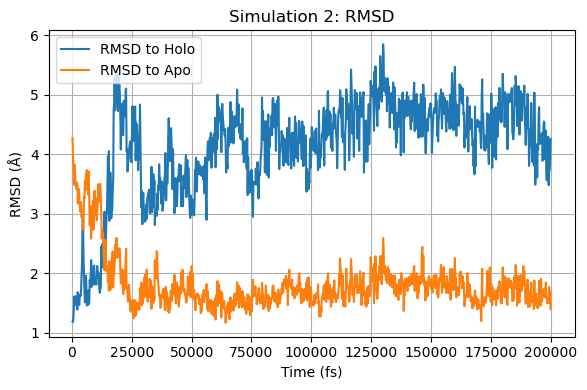

In [28]:
# post process the data for only 1 sim

NN_training_dir = f"{os.getcwd()}/../ensembleFolding/exp2_enzyme_preliminary/bin/1sim"
os.makedirs(NN_training_dir, exist_ok=True)

sims = [2]
results = {}

for sim in sims:
    apo_top = "Simulations/Apo/1anf_malremoved_t3p.parm7"
    apo_dcd = f"Simulations/Apo/simulation_{sim:02d}/npt_production_{sim:02d}.dcd"    
    hol_top = "Simulations/Holo/1anf_mal_t3p.parm7"
    hol_dcd = f"Simulations/Holo/simulation_{sim:02d}/npt_production_{sim:02d}.dcd"

    apo_crystal = f"{os.getcwd()}/Simulations/Apo/1anf_malremoved_tleap.pdb"  # Replace with the actual path to the apo crystal structure
    hol_crystal = f"{os.getcwd()}/Simulations/Holo/1omp.pdb"  # Replace with the actual path to the apo crystal structure

    # Load the apo trajectory
    u = mda.Universe(apo_top, apo_dcd)

    average = align.AverageStructure(u, u, select='protein and name CA', ref_frame=0).run()
    ref = average.results.universe

    # Load the apo crystal structure
    u_crystal_apo = mda.Universe(apo_crystal)

    # Load the holo crystal structure
    u_crystal_hol = mda.Universe(hol_crystal)

    # Align the apo crystal structure to the reference
    align.AlignTraj(u_crystal_apo, ref, select='protein and name CA', in_memory=True).run()

    # Align the holo crystal structure to the reference
    align.AlignTraj(u_crystal_hol, ref, select='protein and name CA', in_memory=True).run()

    # Select the protein atoms in the apo trajectory and the apo crystal structure
    protein_atoms_traj_apo = u.select_atoms('protein and name CA')
    protein_atoms_crystal_apo = u_crystal_apo.select_atoms('protein and name CA')

    # Select the protein atoms in the holo trajectory and the holo crystal structure
    protein_atoms_crystal_hol = u_crystal_hol.select_atoms('protein and name CA')

    # Calculate RMSD for apo
    RMSD_hol = rms.RMSD(protein_atoms_traj_apo, protein_atoms_crystal_apo).run()

    # Calculate RMSD for holo
    RMSD_apo = rms.RMSD(protein_atoms_traj_apo, protein_atoms_crystal_hol).run()

    # Extract timeseries data using the `.timeseries()` method
    # Shape: (num_frames, num_CA_atoms, 3)
    uptoIdx = np.ceil(200 / 200 * u.trajectory.n_frames).astype(int)
    Xtraj = np.empty((uptoIdx, protein_atoms_traj_apo.n_atoms, 3))

    # Iterate over the entire trajectory and store Cα positions
    for i, y_clustered in enumerate(u.trajectory[:uptoIdx]):
        Xtraj[i] = protein_atoms_traj_apo.positions  # Store positions of Cα atoms

    # Store results in the dictionary
    results[sim] = {
        'RMSD_apo': RMSD_apo,
        'RMSD_hol': RMSD_hol,
        'protein_atoms_traj_apo': protein_atoms_traj_apo,
        'protein_atoms_crystal_apo': protein_atoms_crystal_apo,
        'protein_atoms_crystal_hol': protein_atoms_crystal_hol,
        'Xtraj': Xtraj
    }

    # Plot RMSD against time for both apo and holo
    plt.figure(figsize=(6, 4))
    plt.plot(RMSD_hol.rmsd[:, 1], RMSD_hol.rmsd[:, 2], label=f'RMSD to Holo')
    plt.plot(RMSD_apo.rmsd[:, 1], RMSD_apo.rmsd[:, 2], label=f'RMSD to Apo')
    plt.xlabel('Time (fs)')
    plt.ylabel('RMSD (Å)')
    plt.title(f'Simulation {sim}: RMSD')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"{os.getcwd()}/Simulations/Apo/simulation_{sim:02d}/RMSD_{sim}.png")
    plt.savefig(f"{os.getcwd()}/Simulations/Apo/simulation_{sim:02d}/RMSD_{sim}.pdf")
    plt.savefig(f"{NN_training_dir}/RMSD_to_closed_{sim}.png")
    plt.savefig(f"{NN_training_dir}/RMSD_to_closed_{sim}.pdf")
    plt.show()
